# Electricity Monthly Demand Forecast
# EDA

## Packages

In [2]:
# psycopg2: python package to deal with a postgres database
# pip install psycopg2
import psycopg2
from psycopg2.extras import execute_values

In [3]:
import numpy as np
import pandas as pd
import warnings

import os

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Librería para obtener el usuario que está ejecutando el script
import getpass

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore", category=Warning)
# Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# In max_columns and max_rows ‘None’ value means unlimited.
pd.set_option('display.max_rows', 100)
# Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.1f}'.format

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
# ML and statistics Packages
# pip install statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import autocorrelation_plot

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.optimize import curve_fit

In [6]:
path_data = r'C:\Users\Usuario\OneDrive\0-Data Science\data_science\energy_demand\data'

## Support Functions

In [7]:
def build_postgres_cnxn(database, host, user, password, port=5432, string_connection=None, verbose=True):
    error_txt = ''
    process_ok = True
    cnxn = None
    cursor = None
    if (not host or not user or not password) and not string_connection:
        process_ok = False
        error_txt = 'ERROR build_postgres_cnxn: Error trying to Build DB connexion: you missed to send host, user or password, or string connection. ' +\
                    ' host: ' + (host if host else 'Missed. ') +\
                    ' user: ' + (user if user else 'Missed.') +\
                    ' password: ' + (password if password else 'Missed.') +\
                    ' String Connection: ' + (string_connection if string_connection else 'Missed.')
        if verbose:
            print(error_txt)
    else:
        if not database:
            if verbose:
                print('WARNING build_postgres_cnxn: no database name provided.')
        try:
            if not string_connection:
                cnxn = psycopg2.connect(database=database, host=host, user=user, password=password, port=port)
            else:
                cnxn = psycopg2.connect(string_connection)
            cursor = cnxn.cursor()
            if verbose:
                print('INFO Module build_postgres_cnxn: DB Connection to host', host, 'Ok')
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            if not string_connection:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database host: ' + host + ' user ' +\
                      user + ' port: ' + str(port) +'\n' + txt)
            else:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database string_connection: ' + string_connection +'\n' + txt)
    return process_ok, error_txt, cnxn, cursor


In [8]:
def pg_select_to_pandas(cursor, sql_query, verbose=True):
    error_txt = ''
    process_ok = True
    df = pd.DataFrame()
    if (not cursor or not sql_query):
        process_ok = False
        error_txt = 'ERROR pg_select_to_pandas: No cursor or Query sent as parameter. ' +\
              ' cursor: ' + (' received.' if cursor else ' missed,') +\
              ' query: ' + (sql_query if sql_query else ' missed.')
        if verbose:
            print(error_txt)
    else:
        try:
            cursor.execute(sql_query)
            data = cursor.fetchall()
            colnames = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data=data, columns=colnames)
            if verbose:
                print('INFO pg_select_to_pandas: query executed Ok. Number of records returned: ' + str(df.shape[0]))
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            error_txt = 'ERROR pg_select_to_pandas: Error executing query on host: ' + cursor.connection.info.host + ' database ' +\
                  cursor.connection.info.dbname + ' query: ' + sql_query +'\n' + txt
            if verbose:
                print(error_txt)
    return process_ok, error_txt, df

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
#plot_event(df_hist, element, '2021-09-01', '2022-08-30', ['press_suc', 'press_1', 'press_2'], [], title=element
#    , xposition=[], yposition=[33.9, 89, 90], fig_size=[15, 5], return_df=False)

# List of colors for plots
colors = ['darksalmon',  'royalblue', 'aquamarine', 'darkturquoise', 'magenta', 'maroon', 'lightslategray', 'sienna'
    , 'darkseagreen', 'ghostwhite', 'gold', 'gray', 'goldenrod', 'lightskyblue', 'silver', 'skyblue', 'salmon', 'royalblue'
    , 'saddlebrown', 'aqua', 'sandybrown', 'mediumslateblue', 'mediumaquamarine']

def plot_df(df_, time_since, time_until, time_col, left_feat_lst, right_feat_lst, title="", xposition=[], yposition=[]
    , fig_size=[10, 3], return_df=True, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None):
    """Plot a spot in a timeline
        PARAMS:
        df_: dataframe source of data (must have fields "ts")
        ts *: timestamp column in df_
        time_since *: ts start of period to plot
        time_until *: ts end of period to plot
        left_feat_lst *: list of dataframe features to plot using left axis
        right_feat_lst *: list of dataframe features to plot using right axis
        xposition: list of vertical lines to draw
        texts: list of [x, y, string] for function plt.text()
    """
    colors_lst=['deepskyblue', 'skyblue', 'steelblue', 'dodgerblue', 'indianred', 'firebrick', 'lightsalmon', 'darkorange', 'orange']
    if not right_feat_markers and right_feat_lst:
        right_feat_markers = ['--' for feat in right_feat_lst]
    if not left_feat_markers and left_feat_lst:
        left_feat_markers = ['--' for feat in left_feat_lst]
    fig, ax = plt.subplots()
    df_plot = df_[(df_[time_col].between(time_since, time_until))]
    for idx, feat in enumerate(left_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style='-', color=colors_lst[idx], figsize=(fig_size[0], fig_size[1]))
    i=idx+1
    for idx, feat in enumerate(right_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style=right_feat_markers[idx], color=colors_lst[i+idx], figsize=(fig_size[0], fig_size[1])
            , secondary_y=True, lw=1)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if texts:
        for text in texts:
            if len(text) >= 3:
                plt.text(text[0], text[1], text[2], c=text[3])
            else:
                plt.text(text[0], text[1], text[2])
    for xc in xposition:
        ax.axvline(x=xc, color='r', linestyle='--', lw=1);
    for yc in yposition:
        ax.axhline(y=yc, color='r', linestyle='--', lw=1);
    return df_plot if return_df else np.nan

# Data Load from DB

## Hourly Data
After realizing that temperatures dont have a clear correlation with demand, I started to add other variables, like Prices. This data comes in monthly frec, so I repeat the data for every hour in the hourly data.

In [70]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """select timestamp
	, sum(tandil) tandil
	, sum(azul)	azul
	, sum(ezeiza)	ezeiza
	, sum(sanfernando)	sanfernando
	, sum(mdq)	mdq
	, sum(aeroparque)	aeroparque
	, sum(laquiaca)	laquiaca
	, sum(salta) salta
	, sum(jujuy) jujuy
	, sum(tucuman) tucuman
	, sum(resistencia) resistencia	
	, sum(formosa) formosa
	, sum(corrientes) corrientes
	, sum(posadas) posadas
	, sum(comrivadavia) comrivadavia
	, sum(esquel) esquel
	, sum(gallegos) gallegos
	, sum(sanluis) sanluis
	, sum(riocuarto) riocuarto
	, sum(cordoba) cordoba
	, sum(neuquen) neuquen
	, sum(bariloche) bariloche
	, sum(viedma) viedma
	, sum(sanjuan) sanjuan
	, sum(sanrafael) sanrafael
	, sum(mendoza) mendoza
	, sum(rosario) rosario
	, sum(ceres) ceres
from
(
	select timestamp
		, met_station
		, case when met_station='TANDIL AERO' then temp else 0 end as tandil
		, case when met_station='AZUL AERO' then temp else 0 end as azul
		, case when met_station='EZEIZA AERO' then temp else 0 end	as ezeiza
		, case when met_station='SAN FERNANDO AERO' then temp else 0 end	as sanfernando
		, case when met_station='MAR DEL PLATA AERO' then temp else 0 end	as mdq
		, case when met_station='AEROPARQUE AERO' then temp else 0 end	as aeroparque
		, case when met_station='LA QUIACA OBSERVATORIO' then temp else 0 end	as laquiaca
		, case when met_station='SALTA AERO' then temp else 0 end	as salta
		, case when met_station='JUJUY AERO' then temp else 0 end	as jujuy
		, case when met_station='TUCUMAN AERO' then temp else 0 end	as tucuman
		, case when met_station='RESISTENCIA AERO' then temp end as resistencia
		, case when met_station='FORMOSA AERO' then temp else 0 end	as formosa
		, case when met_station='CORRIENTES AERO' then temp else 0 end	as corrientes
		, case when met_station='POSADAS AERO' then temp else 0 end	as posadas
		, case when met_station='COMODORO RIVADAVIA AERO' then temp else 0 end	as comrivadavia
		, case when met_station='ESQUEL AERO' then temp else 0 end	as esquel
		, case when met_station='RIO GALLEGOS AERO' then temp else 0 end as gallegos
		, case when met_station='SAN LUIS AERO' then temp else 0 end	as sanluis
		, case when met_station='RIO CUARTO AERO' then temp else 0 end	as riocuarto
		, case when met_station='CORDOBA AERO' then temp else 0 end	as cordoba
		, case when met_station='NEUQUEN AERO' then temp else 0 end	as neuquen
		, case when met_station='BARILOCHE AERO' then temp else 0 end	as bariloche
		, case when met_station='VIEDMA AERO' then temp else 0 end	as viedma
		, case when met_station='SAN JUAN AERO' then temp else 0 end	as sanjuan
		, case when met_station='SAN RAFAEL AERO' then temp else 0 end	as sanrafael
		, case when met_station='MENDOZA AERO' then temp else 0 end	as mendoza
		, case when met_station='ROSARIO AERO' then temp else 0 end	as rosario
		, case when met_station='CERES AERO' then temp else 0 end	as ceres
	from cammesa_db.hourly_weather
	where met_station in('TANDIL AERO', 'AZUL AERO', 'EZEIZA AERO'
				, 'MAR DEL PLATA AERO', 'SAN FERNANDO AERO'
				, 'AEROPARQUE AERO'
				, 'LA QUIACA OBSERVATORIO', 'SALTA AERO', 'JUJUY AERO', 'TUCUMAN AERO'
				, 'RESISTENCIA AERO', 'FORMOSA AERO', 'CORRIENTES AERO', 'POSADAS AERO'
				, 'COMODORO RIVADAVIA AERO', 'ESQUEL AERO', 'RIO GALLEGOS AERO'
				, 'SAN LUIS AERO', 'RIO CUARTO AERO', 'CORDOBA AERO'
				, 'NEUQUEN AERO', 'BARILOCHE AERO', 'VIEDMA AERO'
				, 'SAN JUAN AERO', 'SAN RAFAEL AERO', 'MENDOZA AERO'
				, 'ROSARIO AERO', 'CERES AERO')
) a
group by timestamp
            """
process_ok, error_txt, df_hourly_temp = pg_select_to_pandas(cursor, sql_query, verbose=True)
df_hourly_temp = df_hourly_temp[df_hourly_temp.timestamp <'2022-10-01']
df_hourly_temp = df_hourly_temp[['timestamp', 'rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']]
df_hourly_temp.shape[0]

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 33959


32856

In [9]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """	select timestamp
                , day_type
                , hourly_local_demand_mwh
                from cammesa_db.hourly_historic_demand
            """
process_ok, error_txt, df_hourly_demand = pg_select_to_pandas(cursor, sql_query, verbose=True)

label_encoder = LabelEncoder()
df_hourly_demand['d_type'] = label_encoder.fit_transform(df_hourly_demand.day_type)
df_hourly_demand['weekday'] = df_hourly_demand.timestamp.dt.weekday
df_hourly_demand['month'] = pd.to_datetime(df_hourly_demand.timestamp.astype(str).str[:8] + "01")
df_hourly_demand.drop(columns=['day_type'], inplace=True)
df_hourly_demand.shape[0]

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 32856


32856

nan

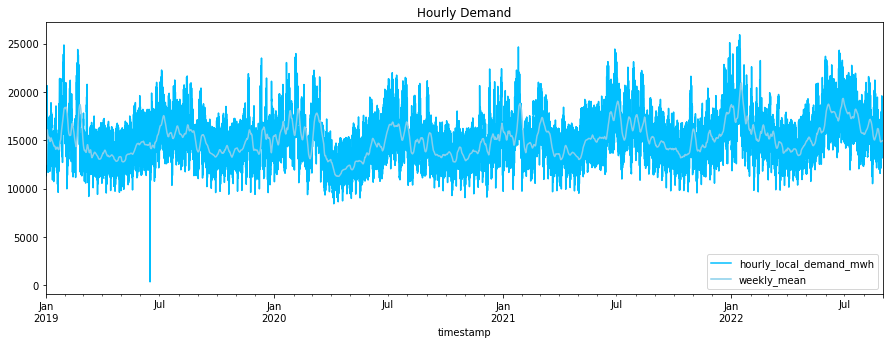

In [10]:
df_roll = df_hourly_demand.copy()
df_roll.set_index('timestamp', inplace=True)
df_roll['daily_mean'] = df_roll['hourly_local_demand_mwh'].rolling(min_periods=1, window='1D').mean()
df_roll['weekly_mean'] = df_roll['hourly_local_demand_mwh'].rolling(min_periods=1, window='7D').mean()
df_roll.reset_index(inplace=True)

plot_df(df_roll, time_since='2019-01-01', time_until='2022-09-01', time_col='timestamp'
    , left_feat_lst=['hourly_local_demand_mwh', 'weekly_mean']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Hourly Demand", xposition=[], yposition=[]
    , fig_size=[15, 5], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [84]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """	select *
                from cammesa_db.monthly_prices
            """
process_ok, error_txt, df_monthly_prices = pg_select_to_pandas(cursor, sql_query, verbose=True)
df_monthly_prices.month = pd.to_datetime(df_monthly_prices.month)
df_monthly_prices = df_monthly_prices[df_monthly_prices.month>='2019-01-01']
df_monthly_prices = df_monthly_prices[['month', 'transp_alta_tens', 'monodico', 'pot_res_med_plzo']]
df_monthly_prices.head()
#df_monthly_prices.drop(columns=['create_user', 'create_date', 'update_user', 'update_date', 'transp_distrib_troncal'], inplace=True)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 117


month  transp_alta_tens  monodico  pot_res_med_plzo
72 2019-01-01            2286.7       2.5              14.0
73 2019-02-01            2577.4       2.6              15.1
74 2019-03-01            2723.5       2.6              16.5
75 2019-04-01            2924.9       2.6              12.4
76 2019-05-01            2892.7       2.7              12.4

In [85]:
df_dataset = df_hourly_demand.merge(df_hourly_temp, on='timestamp', how='left')
df_dataset = df_dataset.merge(df_monthly_prices, on='month', how='left')

## Monthly Data

### Demand

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 129


nan

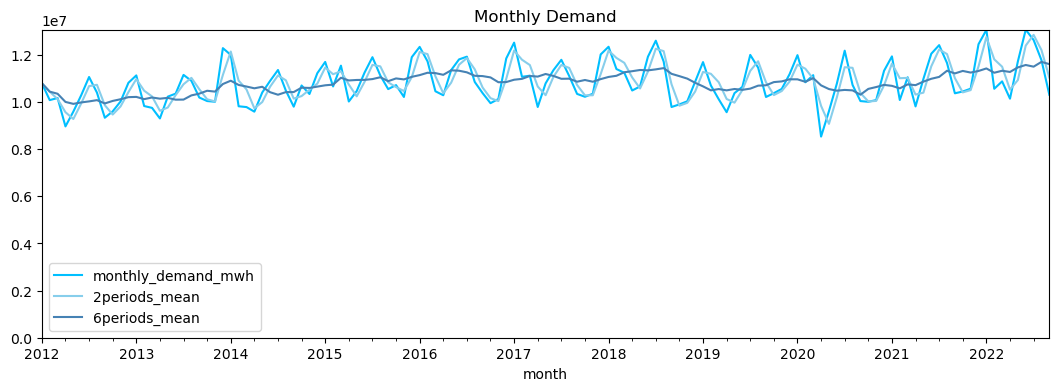

In [10]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """	select month
        	, sum(monthly_demand_mwh)	as monthly_demand_mwh
            from cammesa_db.monthly_demand
            group by month
            order by month
            """
process_ok, error_txt, df_monthly_demand = pg_select_to_pandas(cursor, sql_query, verbose=True)
df_monthly_demand.month = pd.to_datetime(df_monthly_demand.month)
cnxn.close()
df_monthly_demand.columns

df_mdemand = df_monthly_demand.copy()

df_roll = df_mdemand.copy()
df_roll.set_index('month', inplace=True)
df_roll['2periods_mean'] = df_roll['monthly_demand_mwh'].rolling(min_periods=1, window='60D').mean()
df_roll['6periods_mean'] = df_roll['monthly_demand_mwh'].rolling(min_periods=1, window='180D').mean()
df_roll.reset_index(inplace=True)

plot_df(df_roll, time_since='2012-01-01', time_until='2022-09-01', time_col='month'
    , left_feat_lst=['monthly_demand_mwh', '2periods_mean', '6periods_mean']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Monthly Demand", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None
    , ylim=[0, df_roll.monthly_demand_mwh.max()], texts=None)

# Estudios de Correlaciones
Primer estudio es con las variables completamente sumarizadas a nivel país. Ver correlación entre demanda, generación, precios, combustibles, availability by central (by energy type), import/export.

Pendiente caudales, que no hay historia
Cómo conseguir la temperatura??

Probar los modelos a nivel total país.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates

### Correlacion Lineal

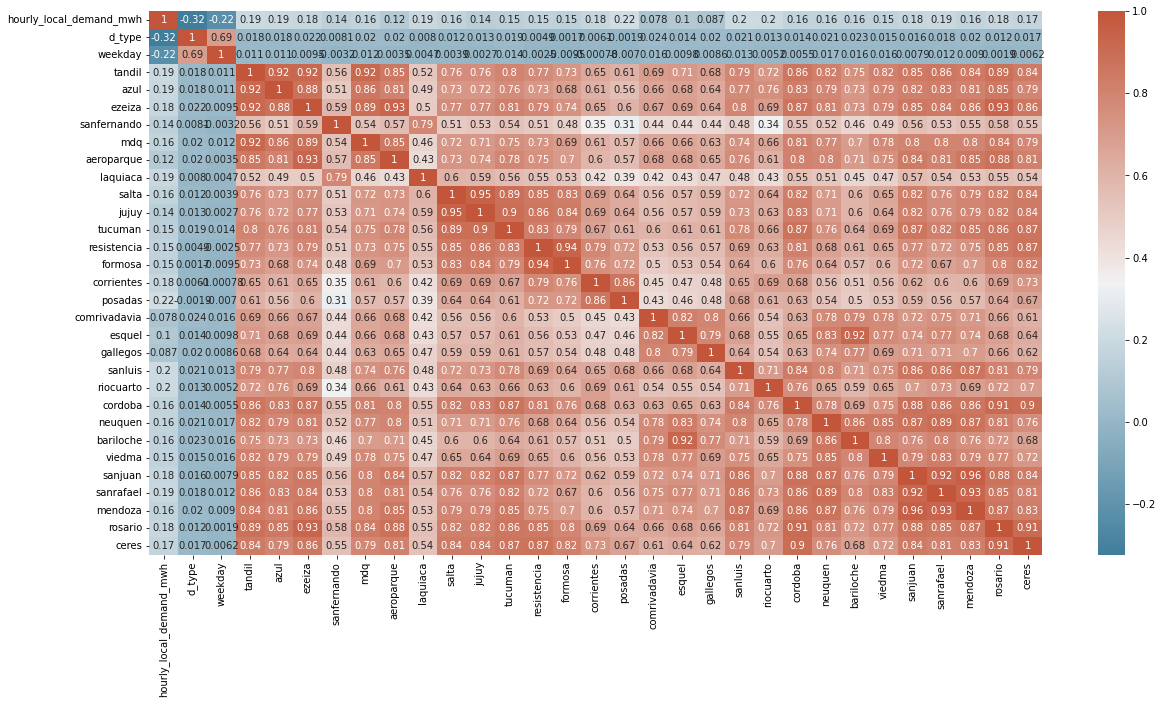

In [35]:
#method{‘pearson’, ‘kendall’, ‘spearman’} default pearson
corr = df_dataset.corr(method='pearson')
%matplotlib inline
plt.figure(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, cmap="Greens", annot=True)
sns.heatmap(corr, cmap=cmap, annot=True)
plt.show()
# Rosario shows great correlation with almost every site. Only Corrientes, Posadas, com Riv, esquel and gallegos, 
# la quiaca and san fernado are less correlated.
# I would mantain: rosario, ezeiza, san fernando, aeroparque, corrientes (corr well with posadas), 
# comrivadavia (well corr with gallegos and esquel)

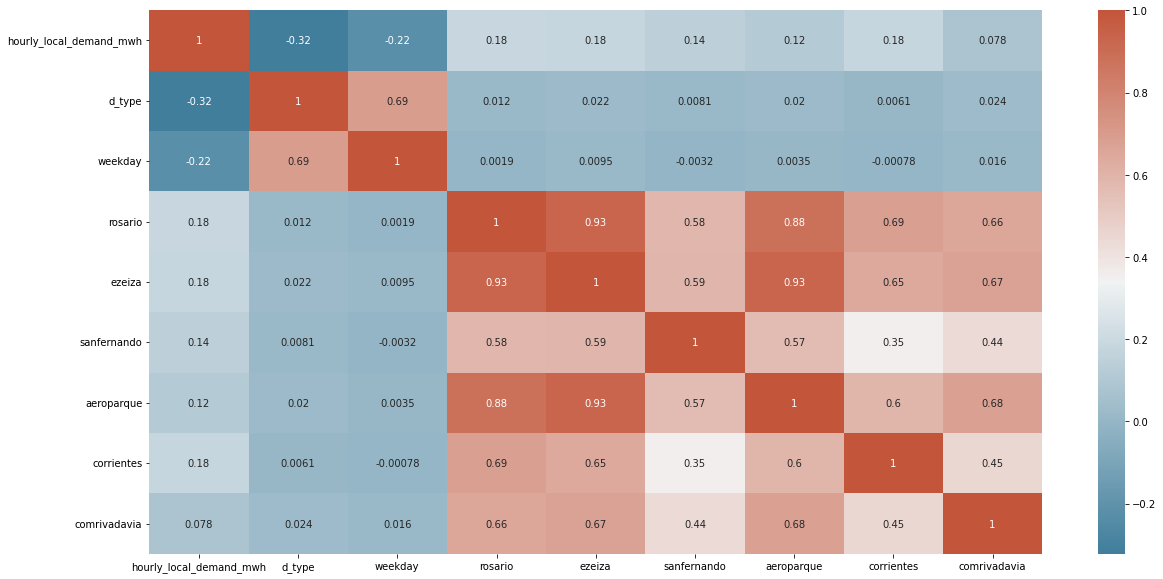

In [43]:
corr = df_dataset[['hourly_local_demand_mwh', 'd_type', 'weekday', 'rosario', 'ezeiza', 'sanfernando'
    , 'aeroparque', 'corrientes', 'comrivadavia']].corr(method='pearson')
%matplotlib inline
plt.figure(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, cmap="Greens", annot=True)
sns.heatmap(corr, cmap=cmap, annot=True)
plt.show()


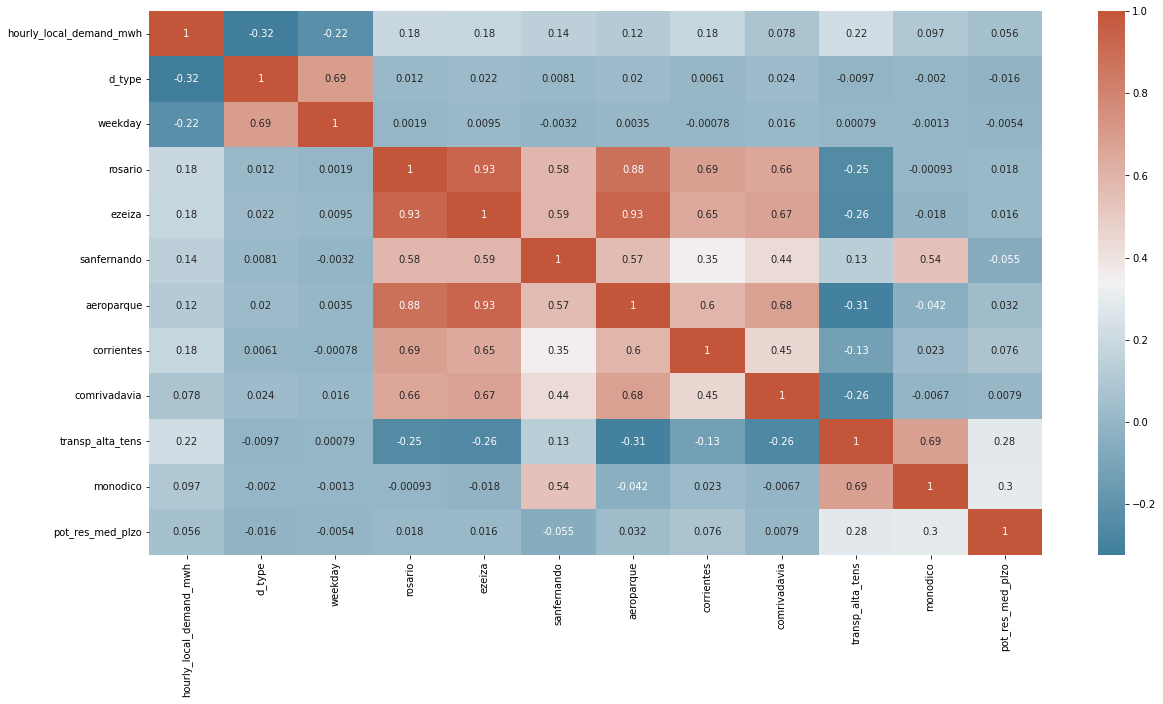

In [86]:
corr = df_dataset.corr(method='pearson')
%matplotlib inline
plt.figure(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, cmap="Greens", annot=True)
sns.heatmap(corr, cmap=cmap, annot=True)
plt.show()

### Correlation among Prices
trans_alta_tens keeps good correlation with almost every other price.<br>
trans_alta_tens, monodico, pot_res_med_plzo

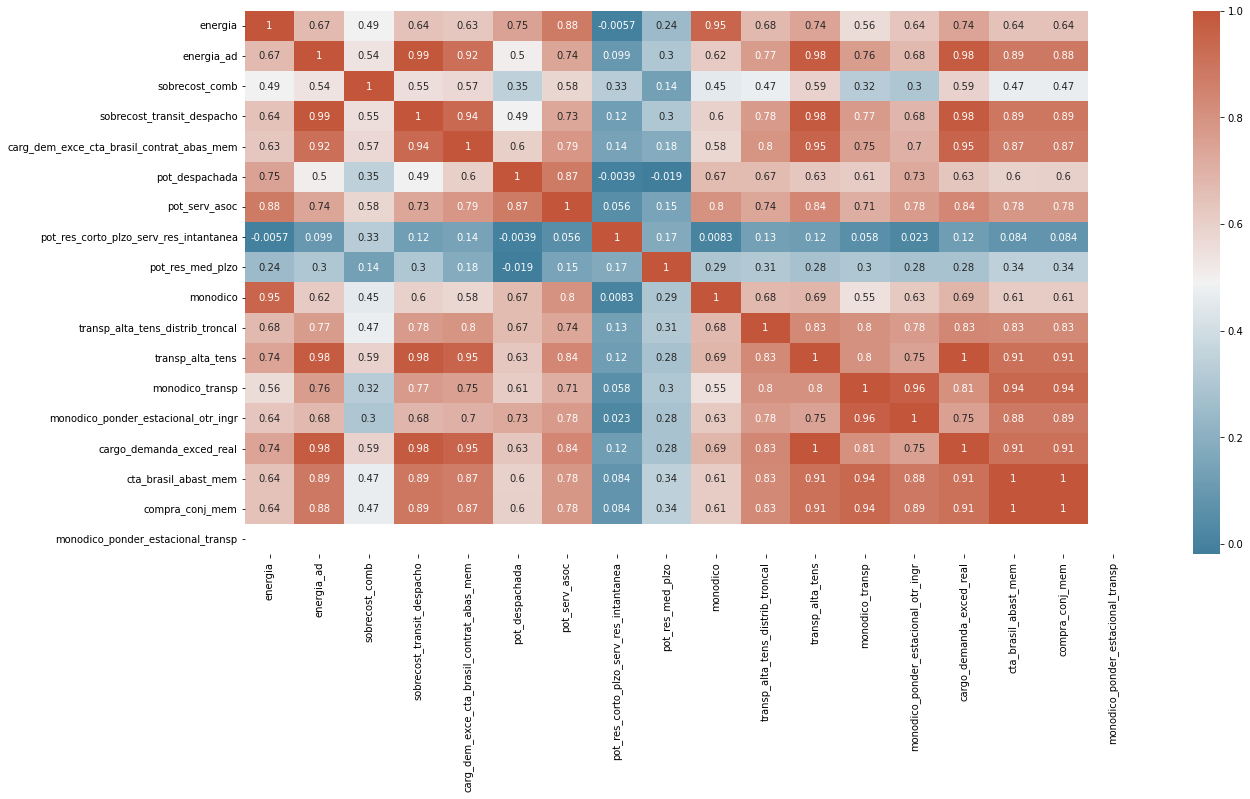

In [80]:
corr = df_monthly_prices.corr(method='pearson')
%matplotlib inline
plt.figure(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, cmap="Greens", annot=True)
sns.heatmap(corr, cmap=cmap, annot=True)
plt.show()

### Correlaciones No lineales

In [95]:
df_dataset.columns
cols = ['hourly_local_demand_mwh', 'd_type', 'weekday', 'rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes'
    , 'comrivadavia', 'transp_alta_tens', 'monodico', 'pot_res_med_plzo']

In [96]:
# Plotting the PPS matrix:
# (This needs some minor preprocessing because seaborn.heatmap unfortunately does not accept tidy data)
# pip install ppscore
import ppscore as pps

matrix_df = pps.matrix(df_dataset[cols])[['x', 'y', 'ppscore']]\
    .pivot(columns='x', index='y', values='ppscore')

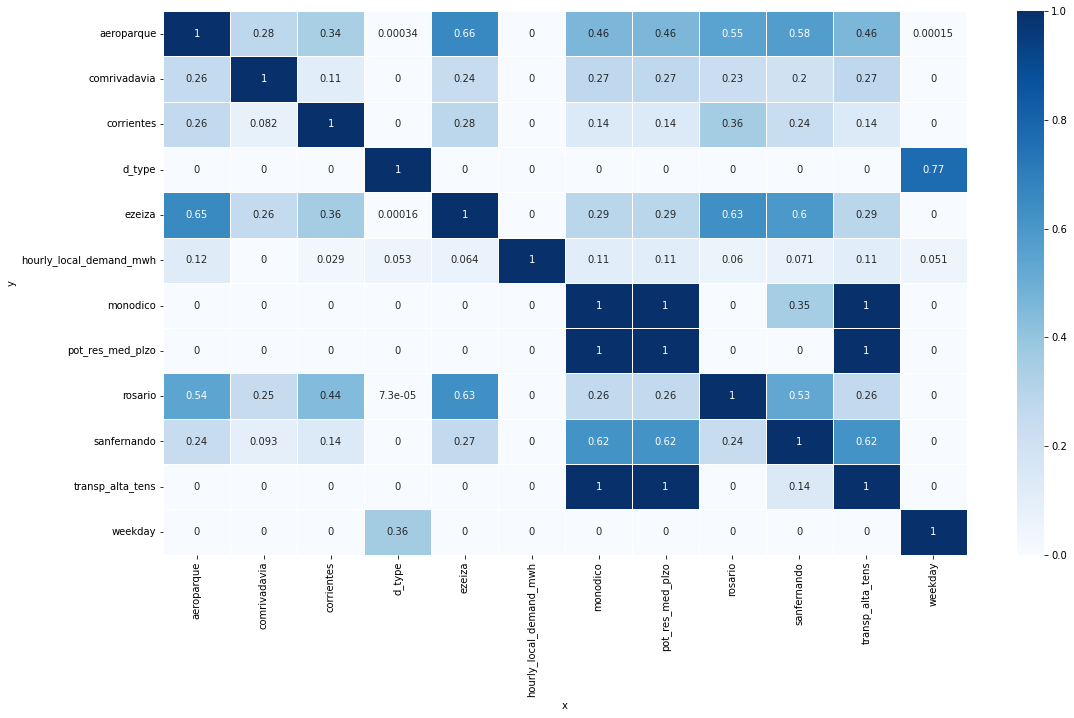

In [97]:
plt.figure(figsize=(18, 10))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True);

# EDA for Time Series Data

### Monthly Demand

nan

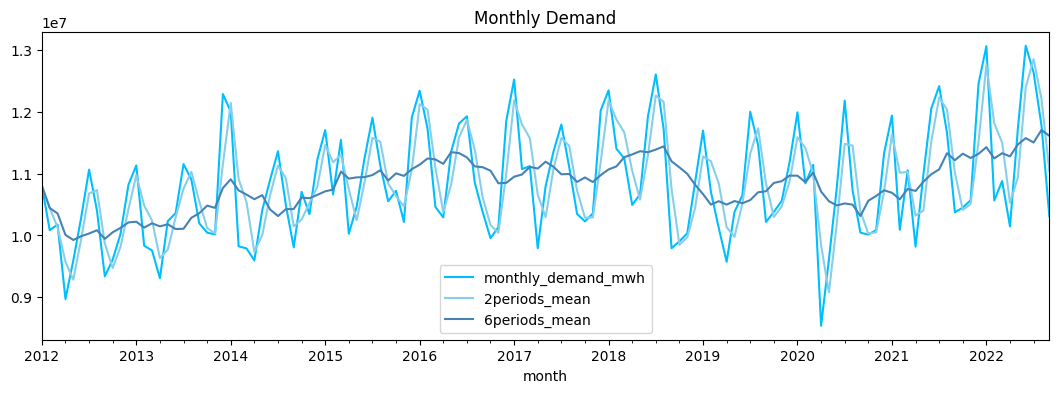

In [12]:
df_roll = df_mdemand.copy()
if df_roll.index.name != 'month':
    df_roll.set_index('month', inplace=True)
df_roll['2periods_mean'] = df_roll['monthly_demand_mwh'].rolling(min_periods=1, window='60D').mean()
df_roll['6periods_mean'] = df_roll['monthly_demand_mwh'].rolling(min_periods=1, window='180D').mean()
df_roll.reset_index(inplace=True)

plot_df(df_roll, time_since='2012-01-01', time_until='2022-09-01', time_col='month'
    , left_feat_lst=['monthly_demand_mwh', '2periods_mean', '6periods_mean']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Monthly Demand", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None
    , ylim=[], texts=None)

### Stationary Tests
https://machinelearningmastery.com/time-series-data-stationary-python/

mean1=10666031.409547, mean2=11005283.824185
variance1=671235339551.065186, variance2=868608775660.905151


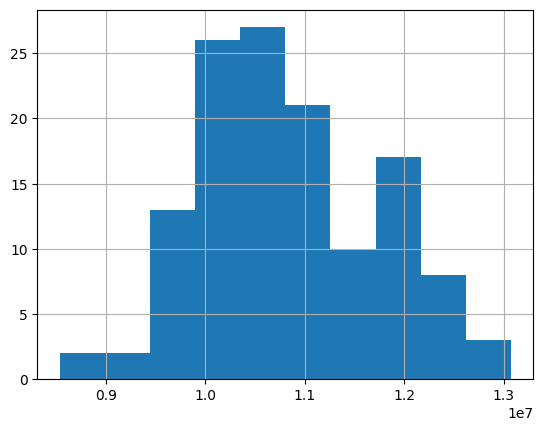

In [13]:
# Not a Normal distribution:
df_mdemand.monthly_demand_mwh.hist()
# Compare statistics from different sequences of time - Mean and Var are very different, they should be simmilar for the series to be
# Stationary
X = df_mdemand.monthly_demand_mwh.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

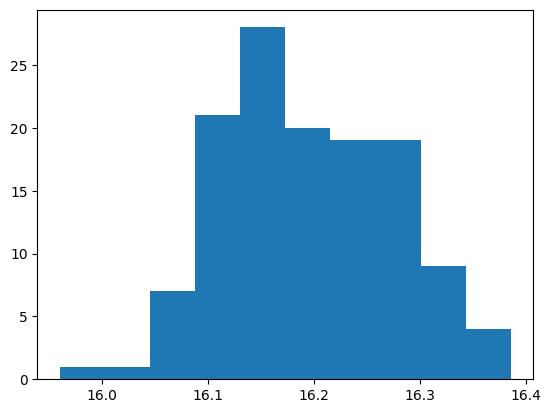

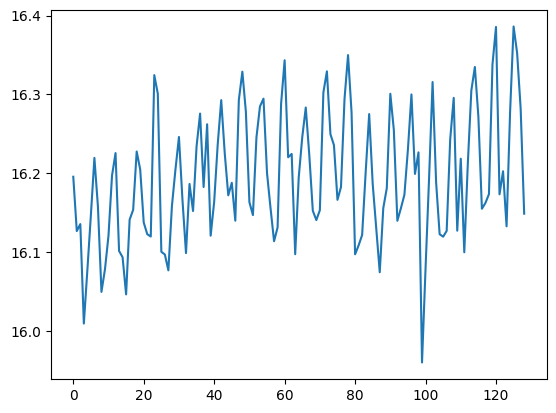

In [14]:
# A log transform can be used to flatten out exponential change back to a linear relationship.
# But, in this case, it didnt work
X = df_mdemand.monthly_demand_mwh.values
X = np.log(X)
plt.hist(X)
plt.show()
plt.plot(X)
plt.show()

### Time Series Stationary - Augmented Dickey-Fuller test ADF
p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.<br>
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

In [15]:
#X = df_mdemand.monthly_demand_mwh.values
#result = adfuller(X)

#X = df_mdemand.set_index('month')[['monthly_demand_mwh']]
X = df_mdemand[['monthly_demand_mwh']]
result = adfuller(X, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.428332
p-value: 0.568621
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


In [15]:
#df_train = df_mdemand[df_mdemand.month<'2019-01-01'].copy() # 7 years
#df_test = df_mdemand[df_mdemand.month>='2019-01-01'][['month', 'monthly_demand_mwh']].copy() # 3++ years
#df_train.set_index('month', inplace=True)
#df_test.set_index('month', inplace=True)

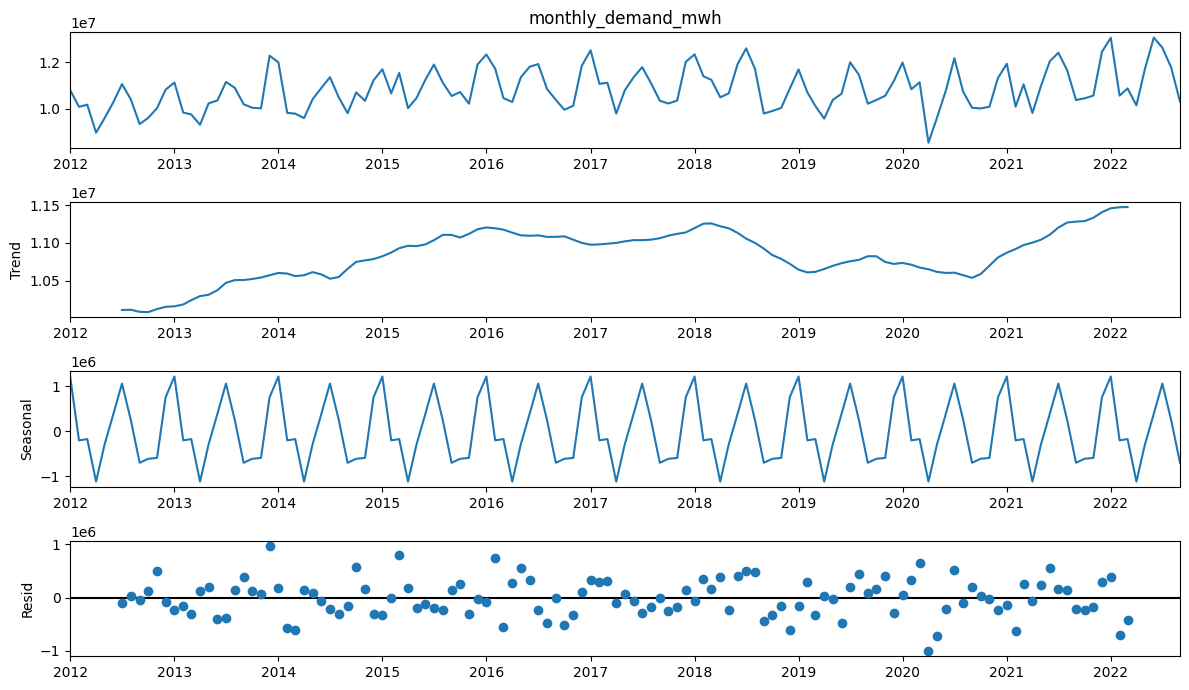

In [16]:
# df_mdemand time range: (Timestamp('2012-01-01 00:00:00'), Timestamp('2022-09-01 00:00:00')) = 129 rows.
# If the time series is an array of numbers, we must specify the frequency of the observations (the period=1 argument). 
# If a Pandas Series object is provided, this argument is not required.
fig = sm.tsa.seasonal_decompose(df_mdemand.set_index('month').monthly_demand_mwh, model='additive').plot()
fig.set_size_inches((12, 7))
# Tight layout to realign things
fig.tight_layout()
plt.show()

### Data Transformation to achieve Stationarity
https://www.kaggle.com/code/freespirit08/time-series-for-beginners-with-arima<br>
https://machinelearningmastery.com/make-sample-forecasts-arima-python/

In [11]:
def test_stationarity(timeseries, period=12, plot_std=True):
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=period).mean()
    movingSTD = timeseries.rolling(window=period).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label=str(period) + ' Periods Rolling Mean')
    if plot_std:
        std = plt.plot(movingSTD, color='black', label=str(period) + ' Periods Rolling Std')
    plt.legend(loc='best')
    plt.title('Stationary Visual Test')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pd.options.display.float_format = '{:.3f}'.format
    print(dfoutput)
    pd.options.display.float_format = '{:.1f}'.format

#### Log Scale Transformation

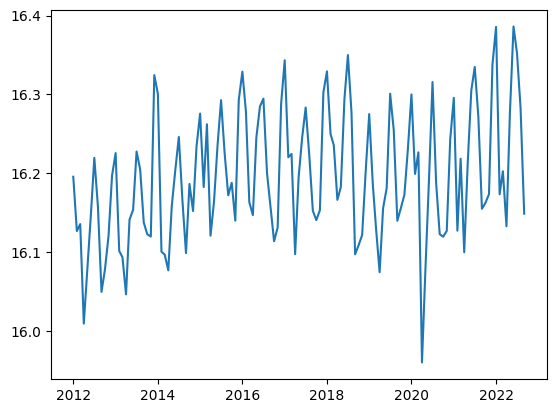

In [18]:
indexedDataset = df_mdemand.set_index('month')[['monthly_demand_mwh']]
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

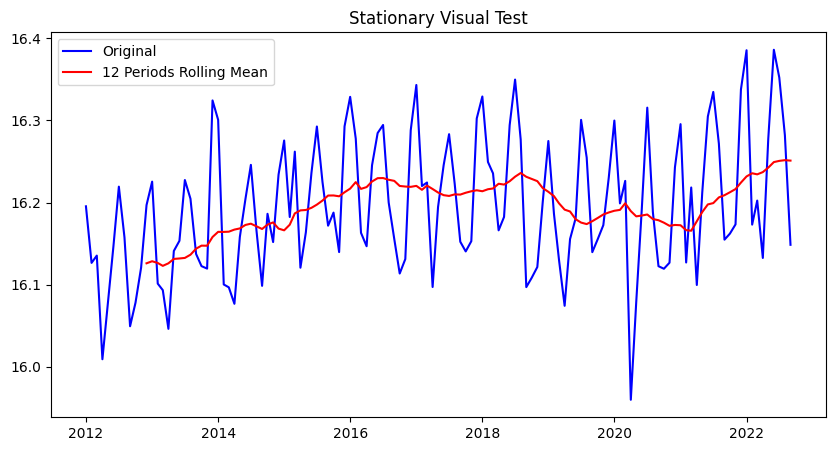

Results of Dickey Fuller Test:
Test Statistic                 -1.366
p-value                         0.599
#Lags Used                     11.000
Number of Observations Used   117.000
Critical Value (1%)            -3.488
Critical Value (5%)            -2.887
Critical Value (10%)           -2.580
dtype: float64


In [19]:
test_stationarity(indexedDataset_logScale, plot_std=False)

#### Remove trend by substracting average from data:

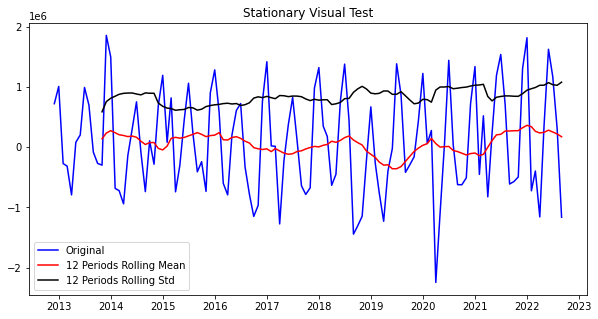

Results of Dickey Fuller Test:
Test Statistic                 -2.487
p-value                         0.119
#Lags Used                     13.000
Number of Observations Used   104.000
Critical Value (1%)            -3.495
Critical Value (5%)            -2.890
Critical Value (10%)           -2.582
dtype: float64


In [243]:
movingAverage = indexedDataset.rolling(window=12).mean()
datasetMinusMovingAverage = indexedDataset - movingAverage
#Remove NAN values
datasetMinusMovingAverage.dropna(inplace=True)
test_stationarity(datasetMinusMovingAverage)

#### Log Scale - Moving Average

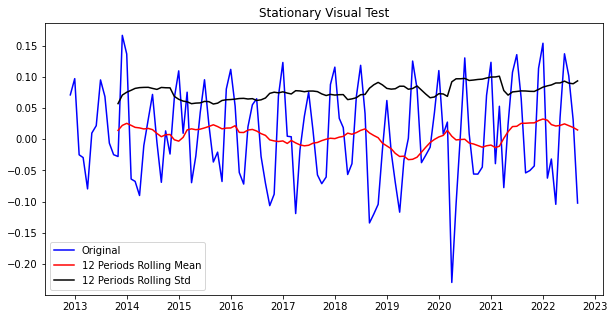

Results of Dickey Fuller Test:
Test Statistic                 -2.487
p-value                         0.119
#Lags Used                     11.000
Number of Observations Used   106.000
Critical Value (1%)            -3.494
Critical Value (5%)            -2.889
Critical Value (10%)           -2.582
dtype: float64


In [244]:
# Remove trend by substracting average (log) from log data:
indexedDataset_logScale = np.log(indexedDataset)
LogmovingAverage = indexedDataset_logScale.rolling(window=12).mean()
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - LogmovingAverage
#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
test_stationarity(datasetLogScaleMinusMovingAverage)

#### Remove trend by substracting average (log) from log data:

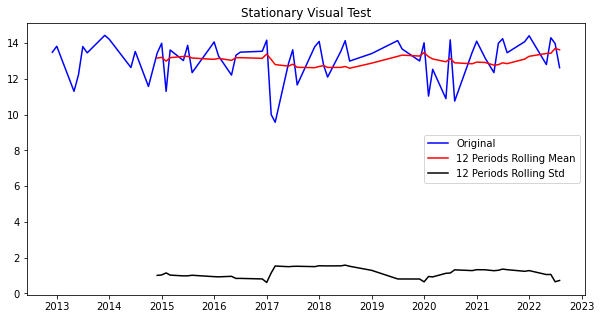

Results of Dickey Fuller Test:
Test Statistic                -7.277
p-value                        0.000
#Lags Used                     0.000
Number of Observations Used   60.000
Critical Value (1%)           -3.544
Critical Value (5%)           -2.911
Critical Value (10%)          -2.593
dtype: float64


In [245]:
# Remove trend by substracting average (log) from log data:
datasetMinusMovingAverage = indexedDataset - indexedDataset.rolling(window=12).mean()
datasetMinusMovingAverage_logScale = np.log(datasetMinusMovingAverage)
#Remove NAN values
datasetMinusMovingAverage_logScale.dropna(inplace=True)
test_stationarity(datasetMinusMovingAverage_logScale)

#### Exponential Decay
A quantity is subject to exponential decay if it decreases at a rate proportional to its current value.

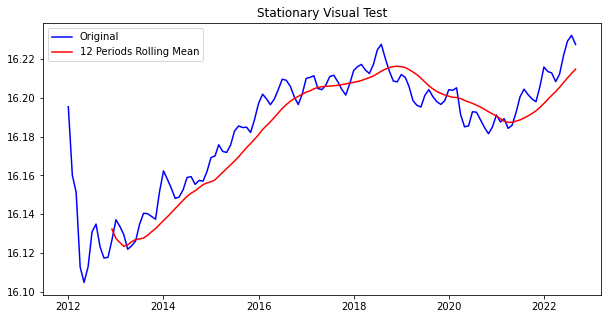

Results of Dickey Fuller Test:
Test Statistic                 -2.550
p-value                         0.104
#Lags Used                     12.000
Number of Observations Used   116.000
Critical Value (1%)            -3.488
Critical Value (5%)            -2.887
Critical Value (10%)           -2.580
dtype: float64


In [246]:
indexedDataset_logScale = np.log(indexedDataset)
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
#plt.plot(indexedDataset_logScale)
#plt.plot(exponentialDecayWeightedAverage, color='red')
test_stationarity(exponentialDecayWeightedAverage, plot_std=False)

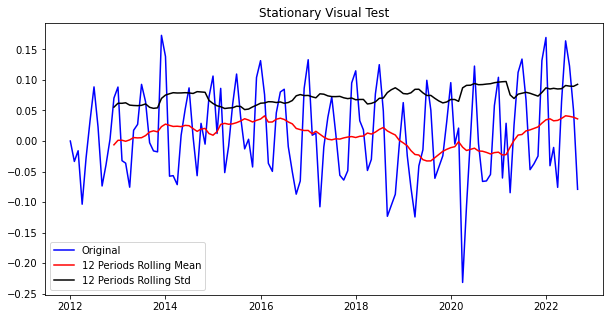

Results of Dickey Fuller Test:
Test Statistic                 -1.623
p-value                         0.471
#Lags Used                     11.000
Number of Observations Used   117.000
Critical Value (1%)            -3.488
Critical Value (5%)            -2.887
Critical Value (10%)           -2.580
dtype: float64


In [247]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

# Model as a Sum of Estimated Components for Trend and Seasonability
https://machinelearningmastery.com/make-sample-forecasts-arima-python/<br>
The data has a strong seasonal component. We can neutralize this and make the data stationary by taking the seasonal difference. That is, we can take the observation for a day and subtract the observation from the same day one year ago.

When working with daily data, an improved model may be to subtract the average temperature from the same calendar month in the previous year, rather than the same day. We can start off by resampling the dataset to a monthly average minimum temperature.

__**Seasonal Adjustment with Modeling**__
We can model the seasonal component directly, then subtract it from the observations.<br>
The seasonal component in a given time series is likely a sine wave over a generally fixed period and amplitude. This can be approximated easily using a curve-fitting method.

https://medium.com/analytics-vidhya/multi-seasonal-time-series-analysis-decomposition-and-forecasting-with-python-609409570007

### Data Load

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 129


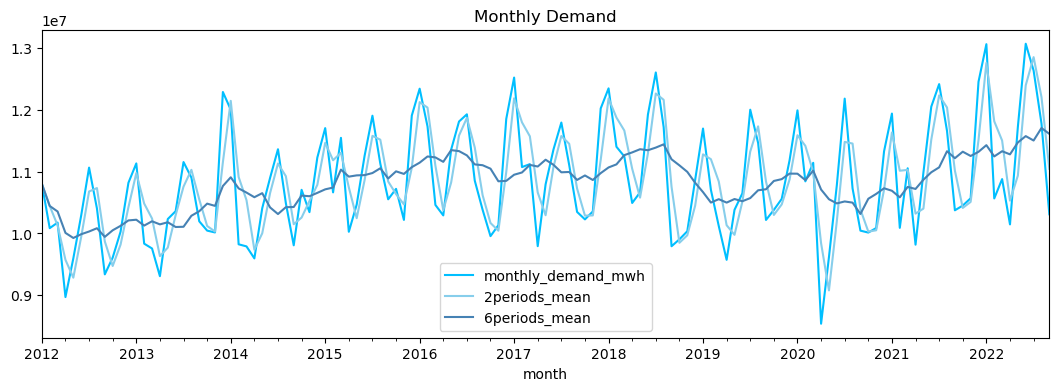

In [12]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """	select month
        	, sum(monthly_demand_mwh)	as monthly_demand_mwh
            from cammesa_db.monthly_demand
            group by month
            order by month
            """
process_ok, error_txt, df_monthly_demand = pg_select_to_pandas(cursor, sql_query, verbose=True)
df_monthly_demand.month = pd.to_datetime(df_monthly_demand.month)
cnxn.close()

df_mdemand = df_monthly_demand.copy()

df_roll = df_mdemand.copy()
if df_roll.index.name != 'month':
    df_roll.set_index('month', inplace=True)
df_roll['2periods_mean'] = df_roll['monthly_demand_mwh'].rolling(min_periods=1, window='60D').mean()
df_roll['6periods_mean'] = df_roll['monthly_demand_mwh'].rolling(min_periods=1, window='180D').mean()
df_roll.reset_index(inplace=True)

plot_df(df_roll, time_since='2012-01-01', time_until='2022-09-01', time_col='month'
    , left_feat_lst=['monthly_demand_mwh', '2periods_mean', '6periods_mean']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Monthly Demand", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

indexedDataset = df_mdemand.copy()
if indexedDataset.index.name != 'month':
    indexedDataset.set_index('month', inplace=True)

#### Seasonal Adjustment with Differencing
https://machinelearningmastery.com/time-series-seasonality-with-python/

In [10]:
# create a differenced series
def difference(dataset, interval=1):
	if type(dataset) == pd.DataFrame:
		series = dataset[[dataset.columns[0]]].values
	else:
		series = dataset
	diff = list()
	for i in range(interval, len(series)):
		value = series[i] - series[i - interval]
		diff.append(value)
	if type(dataset) == pd.DataFrame:
		a = np.empty((interval))
		a[:] = np.nan
		dataset['diff'] = np.append(a, np.array(diff))
		return dataset
	else:
		return np.array(diff)

# invert differenced value
#def inverse_difference(history, yhat, interval=1):
#	return yhat + history[-interval]

## Seasonability Visual Analysis

##### <span style="color: orange;">As I can see, there is NO 3 months seasonability:</span><br>

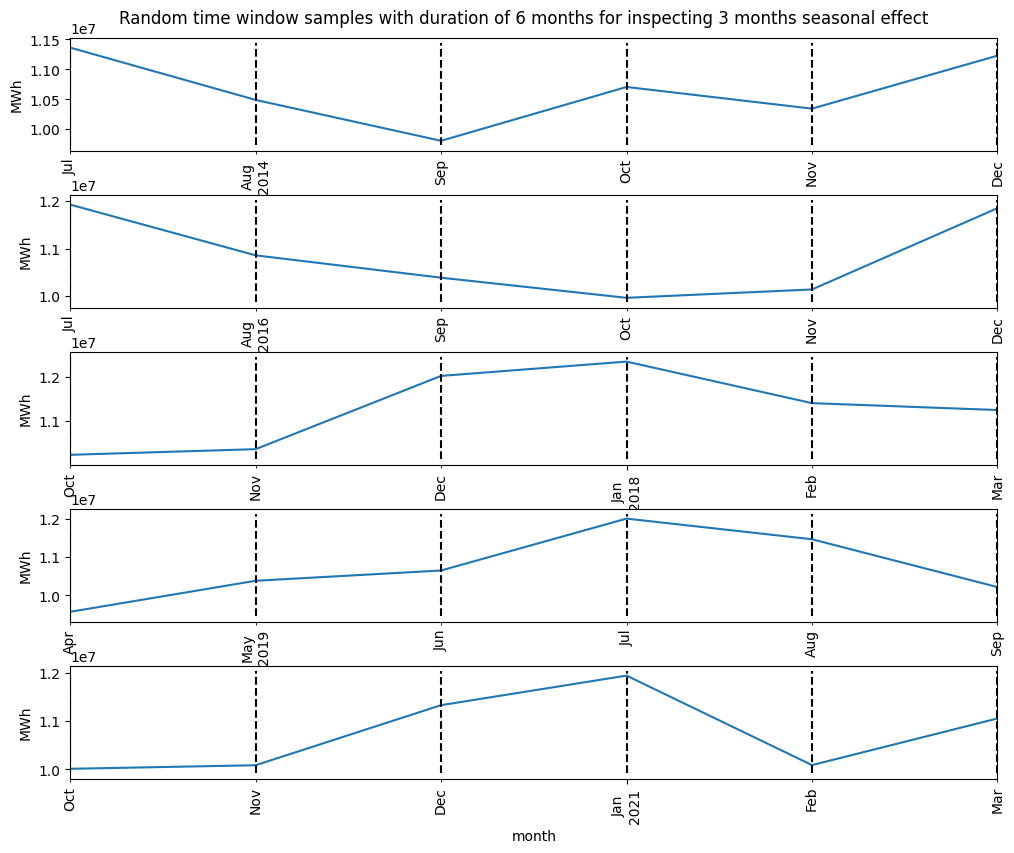

In [22]:
#drawing a random sample of 5 indices without repetition from sub sample
sample = sorted([x for x in np.random.choice([x for x in indexedDataset.index if x.month in [1, 4, 7, 10]], 5, replace=False)])

#checking persistence of 3 months seasonality by inspecting 5 random time window of 6 months
f, axes = plt.subplots(len(sample), 1, figsize=(10, 8)); #dpi=100,
f.tight_layout() #pad=3.0)
plt.suptitle('Random time window samples with duration of 6 months for inspecting 3 months seasonal effect', y = 1.01, fontsize=12)

#plotting time windows and drawing vertical lines at begining of period
for si, s in enumerate(sample):
    ids = indexedDataset.index.to_list().index(s)
    idx = [indexedDataset.iloc[x:x+1,:].index.values for x in range(ids, ids + 6)]
    indexedDataset.iloc[ids:(ids+6),:].plot(ax=axes[si], legend=False, rot=90, ylabel='MWh');
    axes[si].vlines(idx, axes[si].get_ylim()[0], axes[si].get_ylim()[1], colors='black', linestyles='dashed')

##### <span style="color: orange;">It seems, there is 6 months seasonability:</span><br>

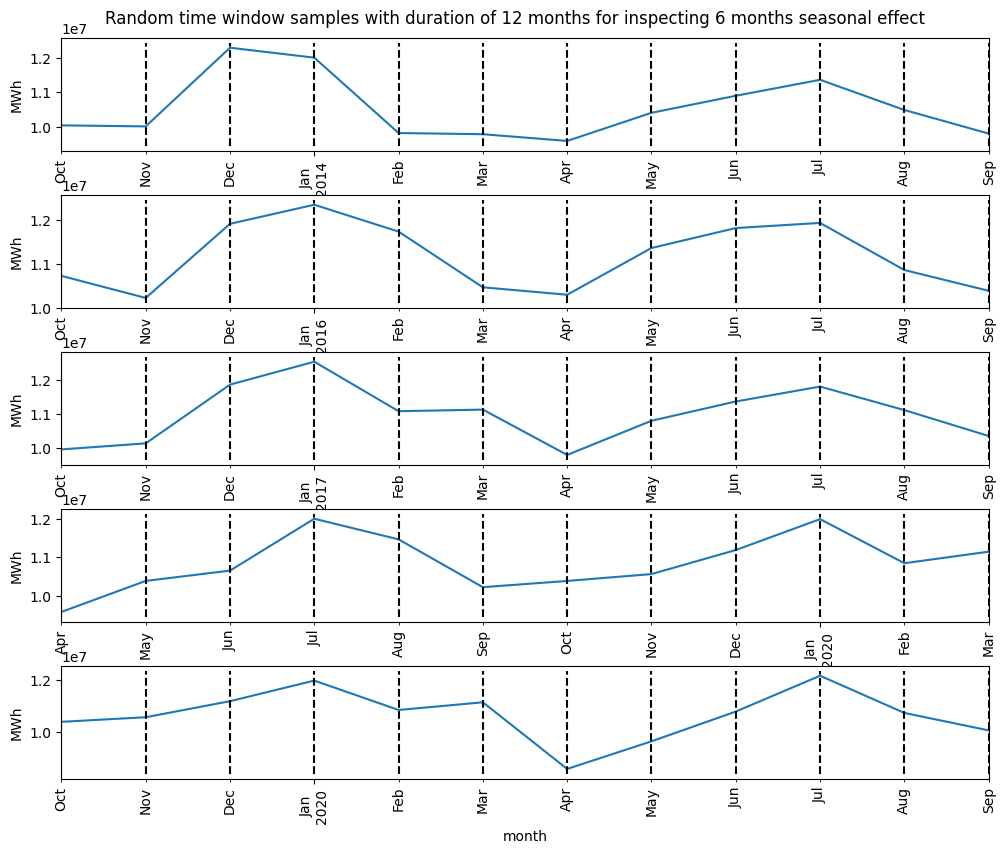

In [23]:
#drawing a random sample of 5 indices without repetition from sub sample
sample = sorted([x for x in np.random.choice([x for x in indexedDataset.index if (x.month in [4, 10]) and (x.year <2022)], 5, replace=False)])

#checking persistence of 6 months seasonality by inspecting 5 random time window of 12 months
f, axes = plt.subplots(len(sample), 1, figsize=(10, 8)); #dpi=100,
f.tight_layout() #pad=3.0)
plt.suptitle('Random time window samples with duration of 12 months for inspecting 6 months seasonal effect', y = 1.01, fontsize=12)

#plotting time windows and drawing vertical lines at begining of period
for si, s in enumerate(sample):
    ids = indexedDataset.index.to_list().index(s)
    idx = [indexedDataset.iloc[x:x+1,:].index.values for x in range(ids, ids + 12)]
    indexedDataset.iloc[ids:(ids+12),:].plot(ax=axes[si], legend=False, rot=90, ylabel='MWh');
    axes[si].vlines(idx, axes[si].get_ylim()[0], axes[si].get_ylim()[1], colors='black', linestyles='dashed')

##### <span style="color: orange;">It seems, there is 12 months seasonability:</span><br>

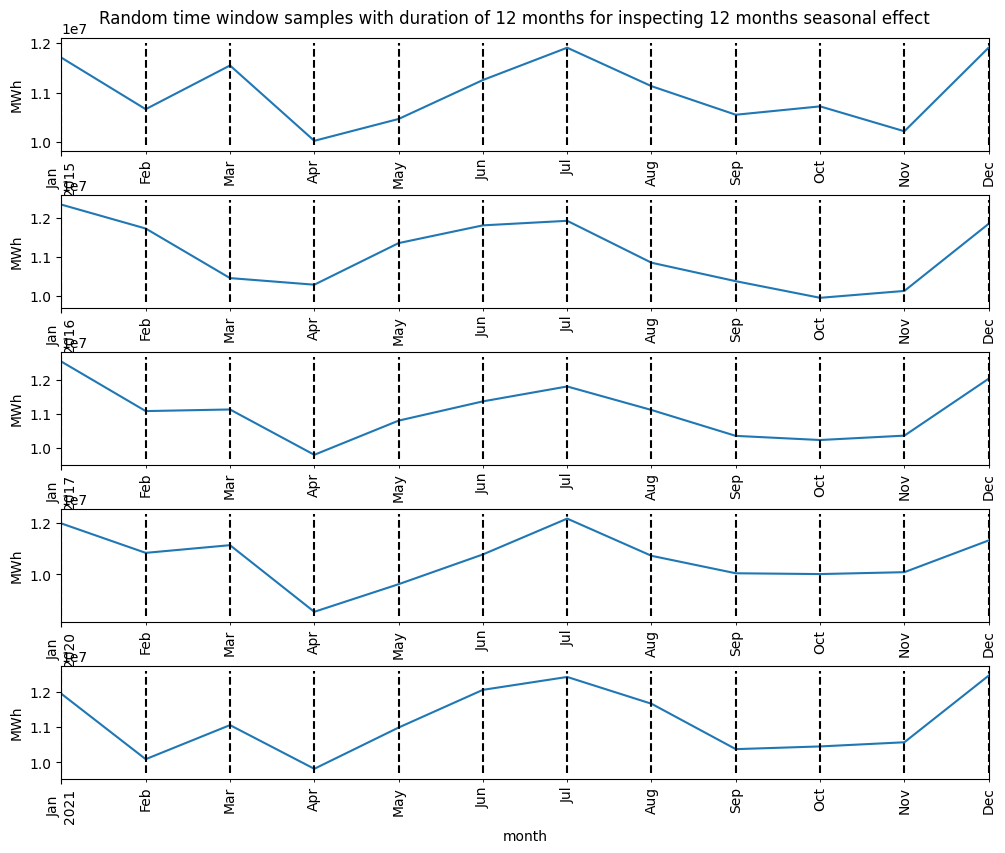

In [24]:
#drawing a random sample of 5 indices without repetition from sub sample
sample = sorted([x for x in np.random.choice([x for x in indexedDataset.index if (x.month in [1]) and (x.year <2022)], 5, replace=False)])

#checking persistence of 6 months seasonality by inspecting 5 random time window of 12 months
f, axes = plt.subplots(len(sample), 1, figsize=(10, 8)); #dpi=100,
f.tight_layout() #pad=3.0)
plt.suptitle('Random time window samples with duration of 12 months for inspecting 12 months seasonal effect', y = 1.01, fontsize=12)

#plotting time windows and drawing vertical lines at begining of period
for si, s in enumerate(sample):
    ids = indexedDataset.index.to_list().index(s)
    idx = [indexedDataset.iloc[x:x+1,:].index.values for x in range(ids, ids + 12)]
    indexedDataset.iloc[ids:(ids+12),:].plot(ax=axes[si], legend=False, rot=90, ylabel='MWh');
    axes[si].vlines(idx, axes[si].get_ylim()[0], axes[si].get_ylim()[1], colors='black', linestyles='dashed')

## Extracting components from time series

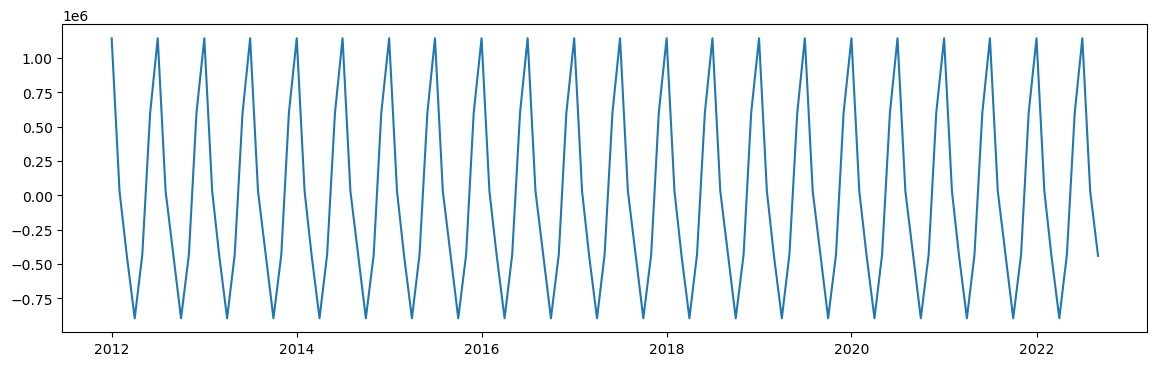

In [13]:
#extracting 6 month seasonality from raw time series
sd_6 = sm.tsa.seasonal_decompose(indexedDataset, period=6)
plt.figure(figsize=(14, 4))
plt.plot(sd_6.seasonal)
plt.show()

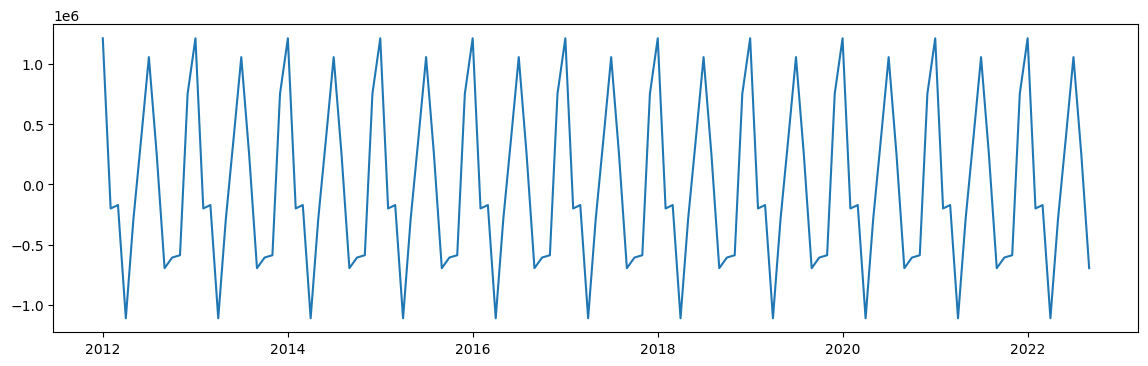

In [15]:
#extracting yearly seasonality from raw time series
sd_12 = sm.tsa.seasonal_decompose(indexedDataset, period=12)
plt.figure(figsize=(14, 4))
plt.plot(sd_12.seasonal)
plt.show()

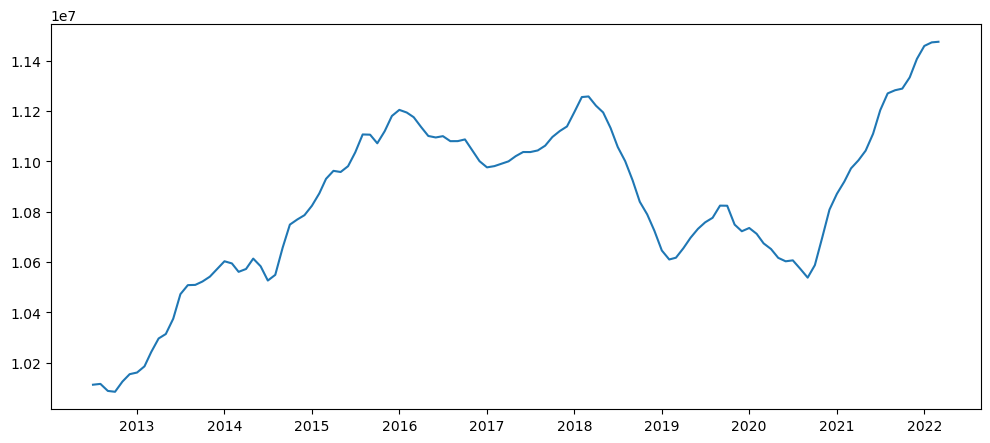

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(sd_12.trend)
plt.show()

#### <span style="color: orange;">Composing the series only with trend and 12 month seasonability gives better results:</span><br>

In [28]:

if df_mdemand.index.name == 'month':
    df_compare = df_mdemand.reset_index(drop=False, inplace=True)
    df_compare = df_compare[['month', 'monthly_demand_mwh']]
else:
    df_compare = df_mdemand[['month', 'monthly_demand_mwh']]

m_data = sd_12.trend + sd_12.seasonal# + sd_6.seasonal
df_compare['md_estimated_12'] = m_data.tolist()
df_compare['diff_12'] = df_compare['monthly_demand_mwh'] - df_compare['md_estimated_12']
m_data = sd_12.trend + sd_12.seasonal + sd_6.seasonal
df_compare['md_estimated_126'] = m_data.tolist()
df_compare['diff_126'] = df_compare['monthly_demand_mwh'] - df_compare['md_estimated_126']
df_compare['12_less_126'] = abs(df_compare['diff_12']) < abs(df_compare['diff_126'])
# There are more opportunities when estimated 12 is better than estimated 126:
print(df_compare[(df_compare['md_estimated_12'].notna()) & (df_compare['12_less_126'])].shape[0],
    df_compare[(df_compare['md_estimated_12'].notna()) & (~df_compare['12_less_126'])].shape[0])
df_compare[12:24]

91 26


month  monthly_demand_mwh  md_estimated_12   diff_12  md_estimated_126   diff_126  12_less_126
12 2013-01-01          11134119.3       11375751.8 -241632.5        12518822.6 -1384703.2         True
13 2013-02-01           9834160.0        9985742.1 -151582.1        10015534.4  -181374.4         True
14 2013-03-01           9756129.3       10070942.9 -314813.6         9628775.1   127354.2        False
15 2013-04-01           9307334.2        9183799.7  123534.5         8287148.8  1020185.3         True
16 2013-05-01          10232825.4       10026055.6  206769.8         9592491.9   640333.5         True
17 2013-06-01          10360537.2       10764129.8 -403592.6        11363649.1 -1003111.9         True
18 2013-07-01          11156173.4       11530600.0 -374426.6        12673670.8 -1517497.4         True
19 2013-08-01          10904479.2       10758312.0  146167.2        10788104.3   116374.9        False
20 2013-09-01          10195873.0        9812993.7  382879.3         9370825.9   825047.1         True
21 2013-10-01          10045715.6        9914748.4  130967.2         9018097.5  1027618.1         True
22 2013-11-01          10015701.7        9953511.9   62189.8         9519948.2   495753.5         True
23 2013-12-01          12291286.5       11324877.1  966409.4        11924396.4   366890.1        False

##### Model as a sum of components vs Observed data seasonal 12 only

Mean absolute error (MAE): 278504, Root mean squared error (RMSE): 345457


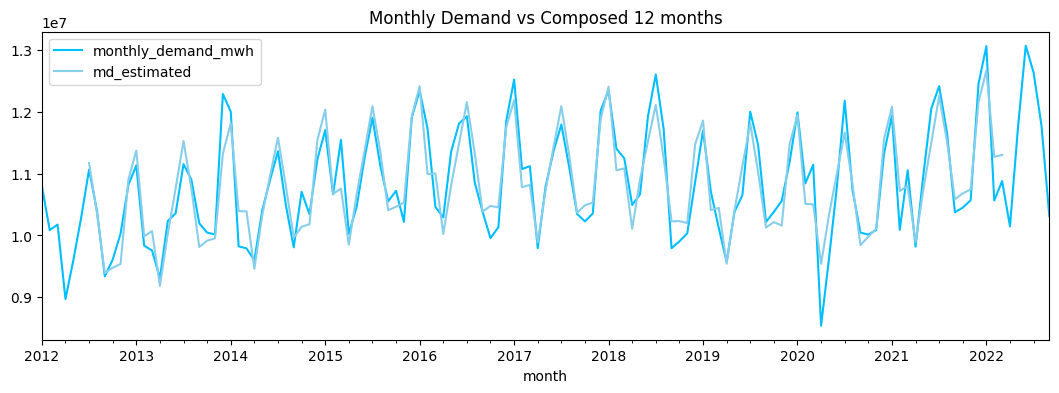

In [29]:
df_plot = df_mdemand[['month', 'monthly_demand_mwh']]
m_data = sd_12.trend + sd_12.seasonal# + sd_6.seasonal
df_plot['md_estimated'] = m_data.tolist()

plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['monthly_demand_mwh', 'md_estimated']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed 12 months", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#calculating mean absolute error and root mean squared error for model evaluation
MAE_sd = mean_absolute_error(df_compare[df_compare.md_estimated_12.notna()].monthly_demand_mwh.values
                            , df_compare[df_compare.md_estimated_12.notna()].md_estimated_12.values)
RMSE_sd = mean_squared_error(df_compare[df_compare.md_estimated_12.notna()].monthly_demand_mwh.values
                            , df_compare[df_compare.md_estimated_12.notna()].md_estimated_12.values, squared=False)

print(f'Mean absolute error (MAE): {"%.0f" % MAE_sd}, Root mean squared error (RMSE): {"%.0f" % RMSE_sd}')

##### Model as a sum of components vs Observed data seasonal 12 + seasonal 6 months

Mean absolute error (MAE): 657077, Root mean squared error (RMSE): 771875


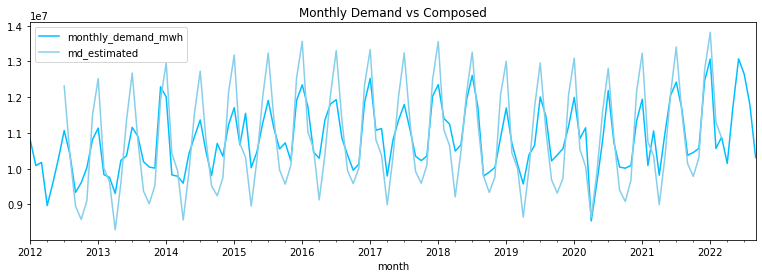

In [58]:
df_plot = df_mdemand[['month', 'monthly_demand_mwh']]
m_data = sd_12.trend + sd_12.seasonal + sd_6.seasonal
df_plot['md_estimated'] = m_data.tolist()

plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['monthly_demand_mwh', 'md_estimated']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#calculating mean absolute error and root mean squared error for model evaluation
MAE_sd = mean_absolute_error(df_compare[df_compare.md_estimated_12.notna()].monthly_demand_mwh.values
                            , df_compare[df_compare.md_estimated_12.notna()].md_estimated_126.values)
RMSE_sd = mean_squared_error(df_compare[df_compare.md_estimated_12.notna()].monthly_demand_mwh.values
                            , df_compare[df_compare.md_estimated_12.notna()].md_estimated_126.values, squared=False)

print(f'Mean absolute error (MAE): {"%.0f" % MAE_sd}, Root mean squared error (RMSE): {"%.0f" % RMSE_sd}')

## Polynomial Estimation of Trend

10837590.822161715 + 310301.29901540995 x**1 MAPE: 2.26 %
10980611.328301774 + 310720.5870759304 x**1 - 421606.6629154852 x**2 MAPE: 1.8 %
10981061.925886674 - 429186.68852486194 x**1 - 423741.25934690953 x**2 +
1211909.8335771575 x**3 MAPE: 1.13 %
11113042.806905983 - 428020.8710543772 x**1 - 1721327.30620233 x**2 +
1208919.2570094094 x**3 + 1488089.225110269 x**4 MAPE: 0.73 %


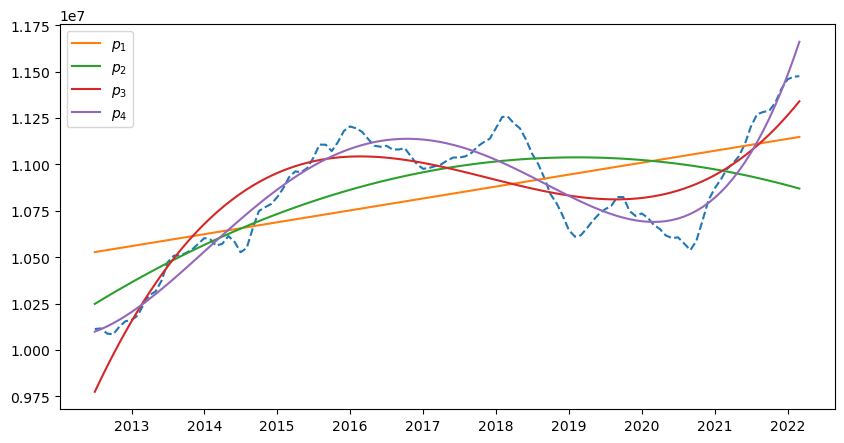

In [16]:
# Exclude Nan records:
sd_12.trend[sd_12.trend.notna()]

# Convert datetime indices to numbers (for Polynomial.fix):
mpl.dates.date2num(sd_12.trend.index.values)

# Yo can access coef of polynomial:
# poly1.coef

# Polynomials by hand:
# recta = lambda x: poly1.coef[0]*x + poly1.coef[1]
# poly_n2 = lambda x: coeff[0]*x**2 + coeff[1]*x + coeff[2]

plt.figure(figsize=(10, 5))
plt.plot(sd_12.trend[sd_12.trend.notna()].index.values, sd_12.trend[sd_12.trend.notna()].values, '--')
for degree in [1, 2, 3, 4]:
    pn = np.polynomial.polynomial.Polynomial.fit(mpl.dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values)
                                            , sd_12.trend[sd_12.trend.notna()].values, deg=degree)
    mape = mean_absolute_percentage_error(sd_12.trend[sd_12.trend.notna()]
            , pn(mpl.dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values))) * 100
    print(pn, 'MAPE:', round(mape, 2), '%')
    plt.plot(sd_12.trend[sd_12.trend.notna()].index.values, pn(mpl.dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values))
                , label='$p_{{{}}}$'.format(degree))
plt.legend()

#### Alternative working with scypy: curve_fit

y = 175.80811 * x + 7798396.09893
Degree: 1 MAPE: 2.26 %
y = 4855.21020 * x + -0.13534 * x^2 + -32507048.54754
Degree: 2 MAPE: 1.8 %
y = 202060.17070 * x + -11.56661 * x^2 + 0.00022 * x^3 + -1164104377.41805
Degree: 3 MAPE: 1.13 %
y = -2952530.94627 * x + 262.97763 * x^2 + -0.01038 * x^3 + 0.00000 * x^4 + 12407834689.91589
Degree: 4 MAPE: 0.73 %


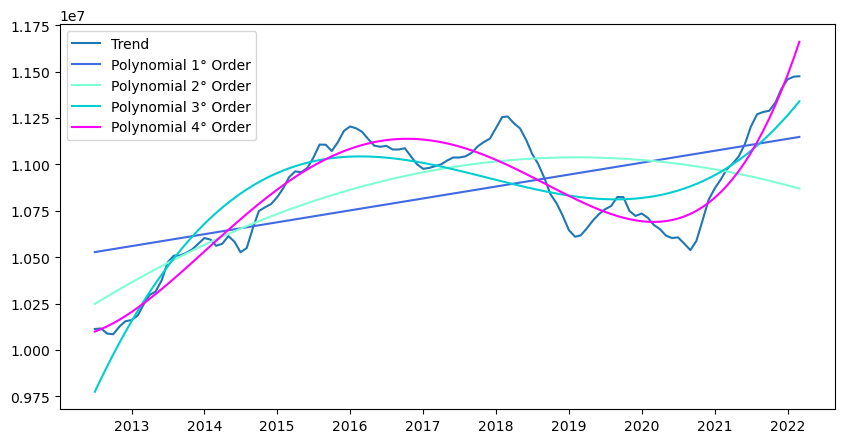

In [17]:
colors_lst=['indianred', 'firebrick', 'lightsalmon', 'darkorange', 'orange', 'deepskyblue', 'skyblue', 'steelblue', 'dodgerblue']

# define the true objective function
def objective1(x, a, b):
	return a * x + b

# define the true objective function
def objective2(x, a, b, c):
	return a * x + b * x**2 + c

# define the true objective function
def objective3(x, a, b, c, d):
	return (a * x) + (b * x**2) + (c * x**3) + d
 
# define the true objective function
def objective4(x, a, b, c, d, e):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + e

# choose the input and output variables
x, y = mpl.dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values), sd_12.trend[sd_12.trend.notna()].values

# define a sequence of inputs between the smallest and largest known inputs
#x_line = np.arange(min(x), max(x), 1)
x_line = sd_12.trend[sd_12.trend.notna()].index.values

plt.figure(figsize=(10, 5))
# plot input vs output
plt.plot(x_line, y, label='Trend')

# curve fit
for degree in [1, 2, 3, 4]:
	if degree == 1:
		popt, _ = curve_fit(objective1, x, y)
		# summarize the parameter values
		a, b = popt
		print('y = %.5f * x + %.5f' % (a, b))
		# calculate the output for the range
		y_line = objective1(x, a, b)
	elif degree == 2:
		popt, _ = curve_fit(objective2, x, y)
		a, b, c = popt
		print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
		y_line = objective2(x, a, b, c)
	elif degree == 3:
		popt, _ = curve_fit(objective3, x, y)
		a, b, c, d = popt
		print('y = %.5f * x + %.5f * x^2 + %.5f * x^3 + %.5f' % (a, b, c, d))
		y_line = objective3(x, a, b, c, d)
	elif degree == 4:
		popt, _ = curve_fit(objective4, x, y)
		a, b, c, d, e = popt
		print('y = %.5f * x + %.5f * x^2 + %.5f * x^3 + %.5f * x^4 + %.5f' % (a, b, c, d, e))
		y_line = objective4(x, a, b, c, d, e)
	mape = mean_absolute_percentage_error(sd_12.trend[sd_12.trend.notna()], y_line) * 100
	print('Degree:', degree, 'MAPE:', round(mape, 2), '%')
	# create a line plot for the mapping function
	plt.plot(x_line, y_line, '-', color=colors[degree], label='Polynomial ' + str(degree) + '° Order')
plt.legend()
plt.show()

## Trigonometrical aproximation of Seasonal component
https://jovian.ai/danielandthelions/hourly-energy-consumption-final/v/1?utm_source=embed#C25

MAPE: 198.35 %


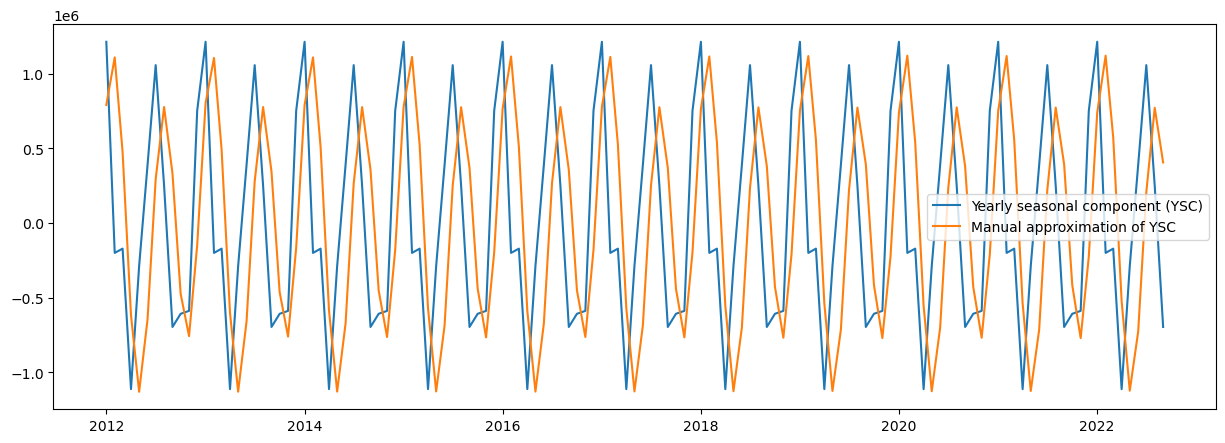

In [18]:
#defining function for approximating yearly seasonal component
#x: datetime, A,C: amplitudes, b,d: phase shifts, E: constant. Periods are predefined
def fy(x, A, b, C, d, E):
    return A * np.sin(4*np.pi/365.5 * x + b) + C * np.cos(2*np.pi/365.5 * x + d) + E

#datetime indices are converted to integers for 'fy' approximation function
tidx = mpl.dates.date2num(sd_12.seasonal.index.values)
y_line = fy(tidx, 950000, 1, 250000, 0.5, 1)
mape = mean_absolute_percentage_error(sd_12.seasonal, y_line) * 100
print('MAPE:', round(mape, 2), '%')

#drawing figure with predefined size and resolution
plt.figure(figsize=(15, 5)); #,dpi=200

#plotting arbitrarily selected time window of observed values
plt.plot(sd_12.seasonal, label='Yearly seasonal component (YSC)');

#plotting manual approximation
#plt.plot(sd_12.seasonal[sd_12.seasonal.notna()].index, fy(tidx, 950000, 1, 250000, -0.25, 1)
#plt.plot(tidx, fy(tidx, 950000, 1, 250000, -0.25, 1)
#plt.plot(tidx, fy(tidx, 250000, 1, 100000, 0.5, 1), label='Manual approximation of YSC');
plt.plot(tidx, y_line, label='Manual approximation of YSC');
plt.legend();

[9.32294875e+05 2.17418977e+00 4.43412703e+04 8.72752144e-01
 2.26167705e+03]
MAPE: 64.78 %


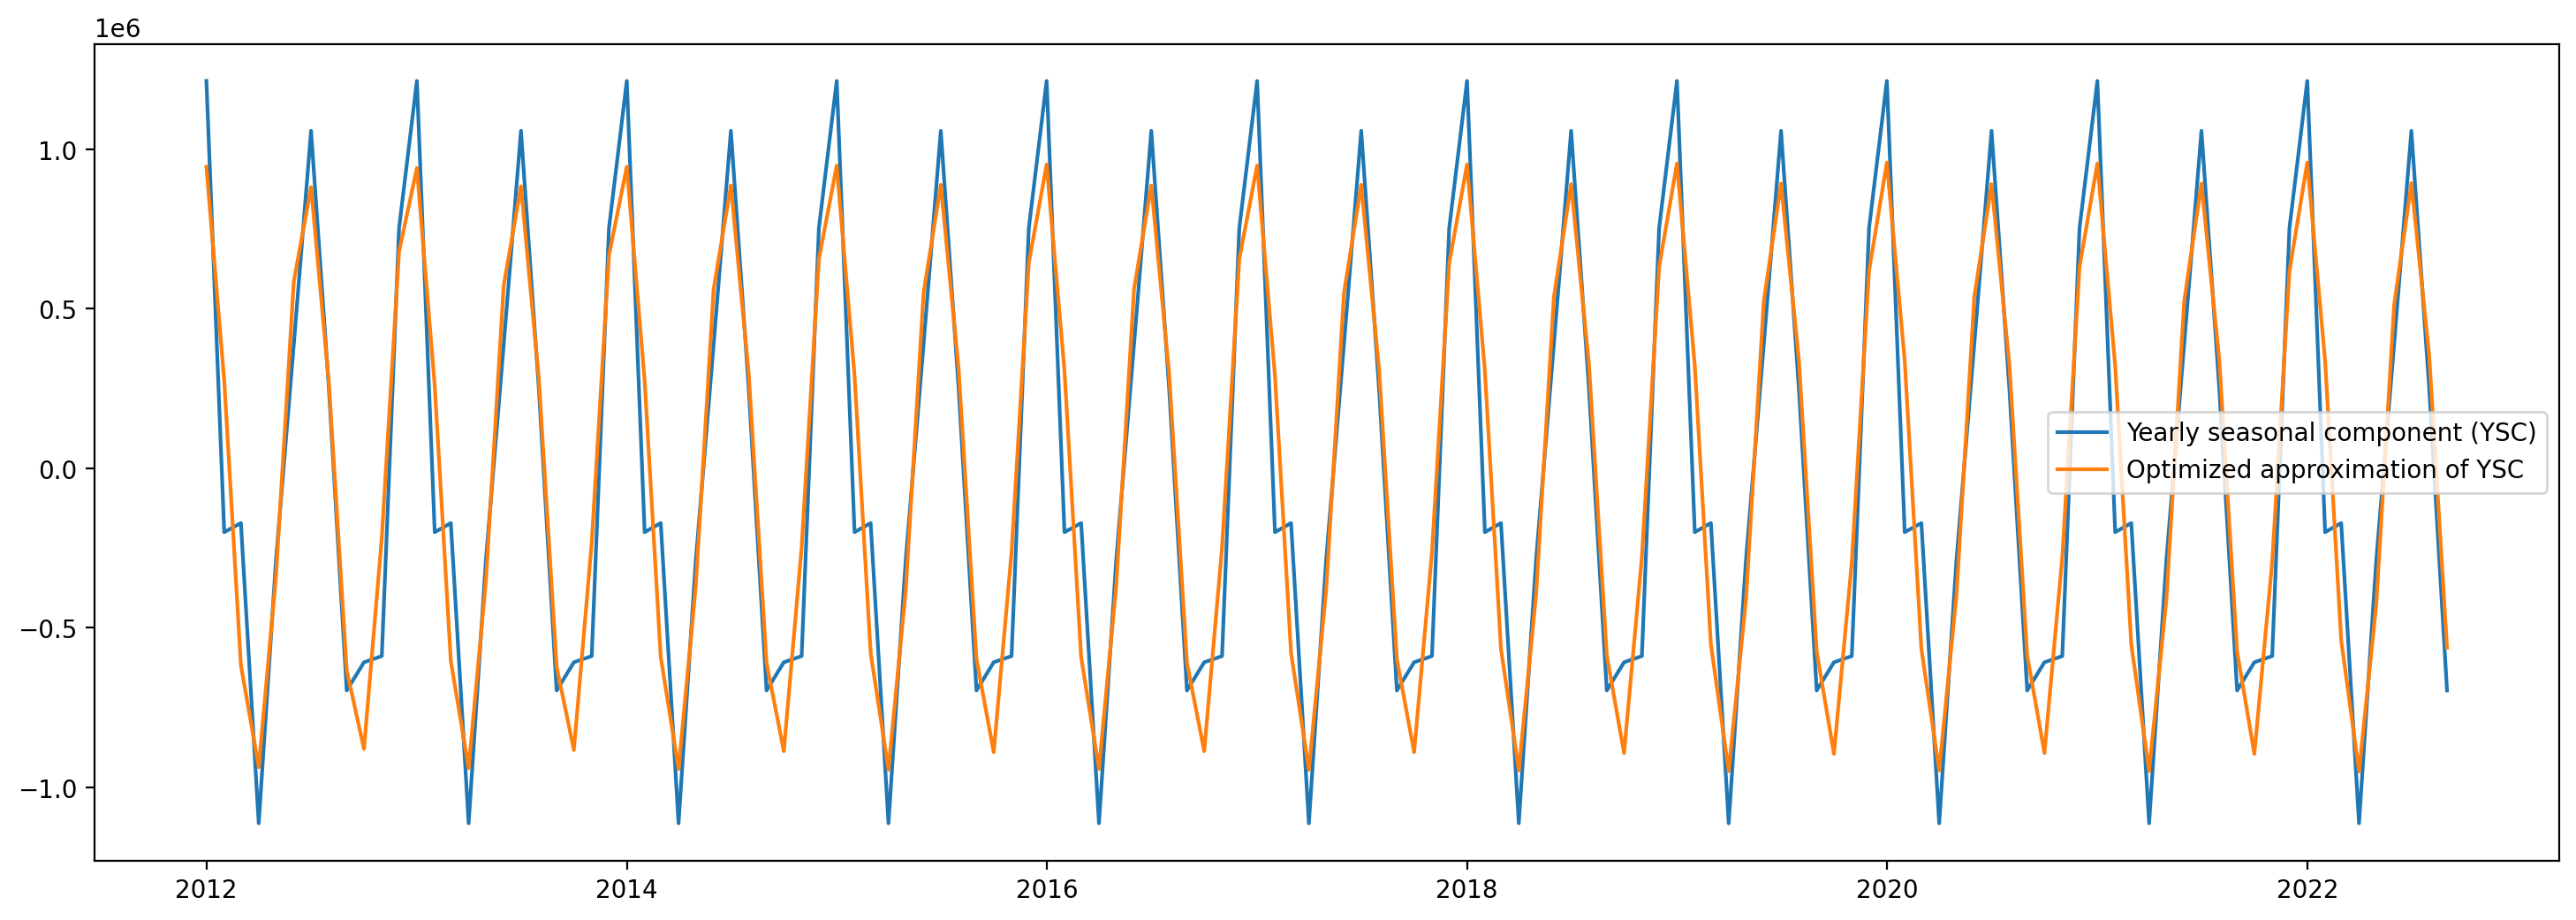

In [19]:
#optimizing manual approximation using scipy
#params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal[sd_12.seasonal.notna()], p0=[950000, 1, 250000, -0.25, 1])
#params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal[sd_12.seasonal.notna()], p0=[250000, 1, 100000, 0.5, 1])
params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal[sd_12.seasonal.notna()], p0=[950000, 1, 250000, 0.5, 1])

#printing parameters for yearly seasonal component optimized approximation ('fy')
print(params_y)
y_line = fy(tidx, params_y[0], params_y[1], params_y[2], params_y[3], params_y[4])

mape = mean_absolute_percentage_error(sd_12.seasonal, y_line) * 100
print('MAPE:', round(mape, 2), '%')

#drawing figure with predefined size and resolution
plt.figure(figsize=(18,6),dpi=200);

#plotting arbitrarily selected time window of observed values
plt.plot(sd_12.seasonal[sd_12.seasonal.notna()], label='Yearly seasonal component (YSC)');

#plotting optimized approximation
plt.plot(sd_12.seasonal[sd_12.seasonal.notna()].index, y_line, label='Optimized approximation of YSC');
plt.legend();

#### What happens if I apply differenciation to remove seasonability?

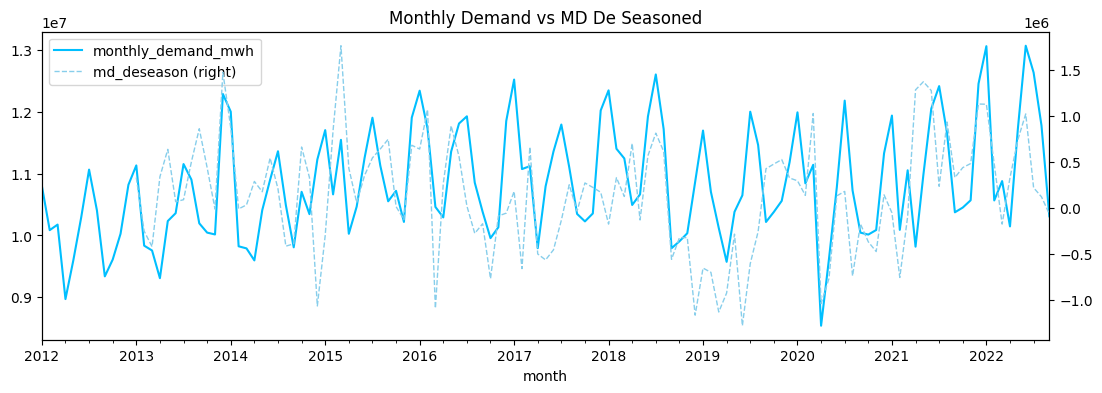

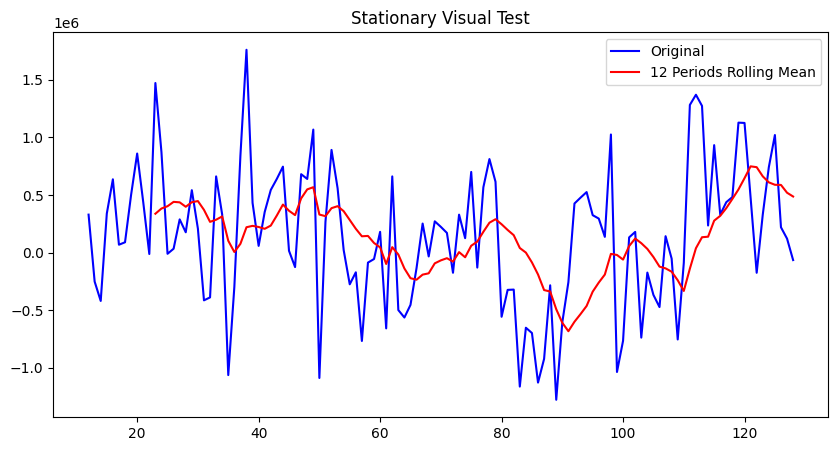

Results of Dickey Fuller Test:
Test Statistic                 -2.744
p-value                         0.067
#Lags Used                     12.000
Number of Observations Used   104.000
Critical Value (1%)            -3.495
Critical Value (5%)            -2.890
Critical Value (10%)           -2.582
dtype: float64


In [35]:
df_plot = df_mdemand.reset_index()[['month', 'monthly_demand_mwh']].copy()
#df_plot['md_deseason'] = df_plot[['monthly_demand_mwh']] - df_plot[['monthly_demand_mwh']].shift(12) Same as diff(12)
df_plot['md_deseason'] = df_plot[['monthly_demand_mwh']].diff(12)
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['monthly_demand_mwh']
    , right_feat_lst=['md_deseason']
    , title="Monthly Demand vs MD De Seasoned", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

test_stationarity(df_plot[df_plot.md_deseason.notna()]['md_deseason'], plot_std=False)

### Model as a sum of components estimated vs Observed data

Mean absolute error (MAE): 371599, Root mean squared error (RMSE): 476376, Mean absolute percentage error (MAPE): 3.4% 


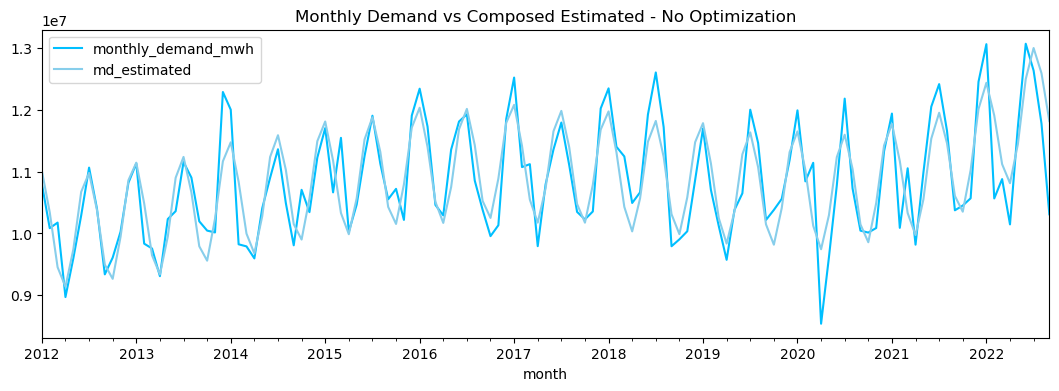

In [18]:
# Trend with polynomial of 4° degree: MAPE total 3.4%
pn = np.polynomial.polynomial.Polynomial.fit(mpl.dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values)
                                            , sd_12.trend[sd_12.trend.notna()].values, deg=4)
trend = pn(mpl.dates.date2num(sd_12.trend.index.values))

# Seasonality with Trigonometrics:
#datetime indices are converted to integers for 'fy' approximation function
tidx = mpl.dates.date2num(sd_12.seasonal[sd_12.seasonal.notna()].index.values)
params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal[sd_12.seasonal.notna()], p0=[950000, 1, 250000, -0.25, 1])
season = fy(tidx, params_y[0], params_y[1], params_y[2], params_y[3], params_y[4])

df_plot = df_mdemand[['month', 'monthly_demand_mwh']]
md_estimated = trend + season
df_plot['md_estimated'] = md_estimated.tolist()

plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['monthly_demand_mwh', 'md_estimated']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed Estimated - No Optimization", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#calculating mean absolute error and root mean squared error for model evaluation
MAE_md = mean_absolute_error(df_plot[df_plot.md_estimated.notna()].monthly_demand_mwh.values
                            , df_plot[df_plot.md_estimated.notna()].md_estimated.values)
RMSE_md = mean_squared_error(df_plot[df_plot.md_estimated.notna()].monthly_demand_mwh.values
                            , df_plot[df_plot.md_estimated.notna()].md_estimated.values, squared=False)
MAPE_md = mean_absolute_percentage_error(df_plot[df_plot.md_estimated.notna()].monthly_demand_mwh.values
                            , df_plot[df_plot.md_estimated.notna()].md_estimated.values) * 100

print(f'Mean absolute error (MAE): {"%.0f" % MAE_md}, Root mean squared error (RMSE): {"%.0f" % RMSE_md}, Mean absolute percentage error (MAPE): {"%.1f" % MAPE_md}% ')

Mean absolute error (MAE): 371599, Root mean squared error (RMSE): 476377, Mean absolute percentage error (MAPE): 3.4% 


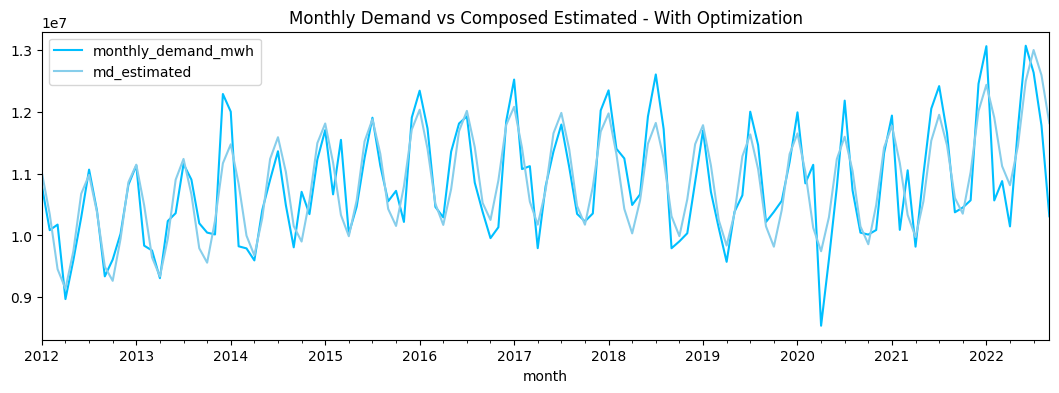

In [37]:
# Trend aproximated with polynomial of 4° degree by curve_fit: MAPE total 3.4%
x, y = mpl.dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values), sd_12.trend[sd_12.trend.notna()].values		
popt, _ = curve_fit(objective4, x, y)
a, b, c, d, e = popt
x = mpl.dates.date2num(sd_12.trend.index.values)
trend = objective4(x, a, b, c, d, e)

# Seasonality with Trigonometrics:
#datetime indices are converted to integers for 'fy' approximation function
tidx = mpl.dates.date2num(sd_12.seasonal[sd_12.seasonal.notna()].index.values)
params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal[sd_12.seasonal.notna()], p0=[950000, 1, 250000, -0.25, 1])
season = fy(tidx, params_y[0], params_y[1], params_y[2], params_y[3], params_y[4])

df_plot = df_mdemand[['month', 'monthly_demand_mwh']]
md_estimated = trend + season
df_plot['md_estimated'] = md_estimated.tolist()

plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['monthly_demand_mwh', 'md_estimated']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed Estimated - With Optimization", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#calculating mean absolute error and root mean squared error for model evaluation
MAE_md = mean_absolute_error(df_plot[df_plot.md_estimated.notna()].monthly_demand_mwh.values
                            , df_plot[df_plot.md_estimated.notna()].md_estimated.values)
RMSE_md = mean_squared_error(df_plot[df_plot.md_estimated.notna()].monthly_demand_mwh.values
                            , df_plot[df_plot.md_estimated.notna()].md_estimated.values, squared=False)
MAPE_md = mean_absolute_percentage_error(df_plot[df_plot.md_estimated.notna()].monthly_demand_mwh.values
                            , df_plot[df_plot.md_estimated.notna()].md_estimated.values) * 100

print(f'Mean absolute error (MAE): {"%.0f" % MAE_md}, Root mean squared error (RMSE): {"%.0f" % RMSE_md}, Mean absolute percentage error (MAPE): {"%.1f" % MAPE_md}% ')

In [44]:
# How estimation differs from real, in %? Should be less than 5%
((df_plot.monthly_demand_mwh - df_plot.md_estimated) / df_plot.monthly_demand_mwh * 100)[-12:]

117     0.9
118    -4.3
119     3.5
120     4.8
121   -12.7
122    -2.2
123    -6.6
124     2.4
125     4.4
126    -2.9
127    -6.9
128   -14.6
dtype: float64

Mean absolute error (MAE): 386756, Root mean squared error (RMSE): 489122, Mean absolute percentage error (MAPE): 3.6% 


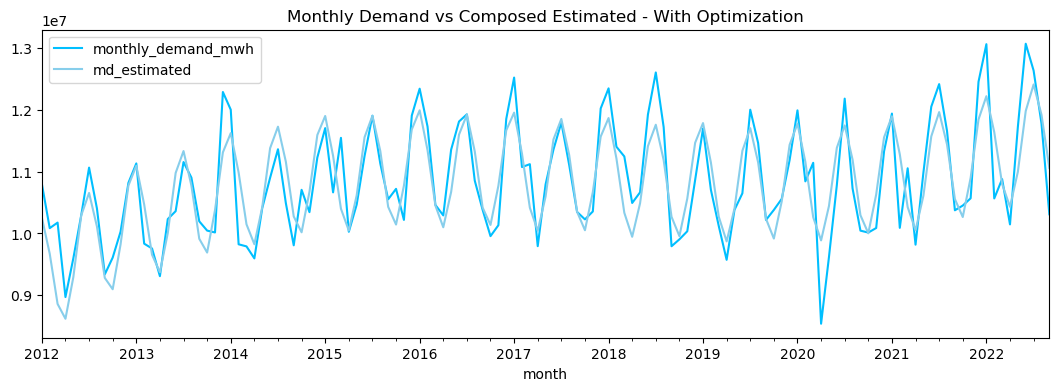

In [20]:
# Trend aproximated with polynomial of 3° degree by curve_fit: MAPE total 3.4%
x, y = mpl.dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values), sd_12.trend[sd_12.trend.notna()].values		
popt, _ = curve_fit(objective3, x, y)
a, b, c, d = popt
x = mpl.dates.date2num(sd_12.trend.index.values)
trend = objective3(x, a, b, c, d)

# Seasonality with Trigonometrics:
#datetime indices are converted to integers for 'fy' approximation function
tidx = mpl.dates.date2num(sd_12.seasonal[sd_12.seasonal.notna()].index.values)
params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal[sd_12.seasonal.notna()], p0=[950000, 1, 250000, -0.25, 1])
season = fy(tidx, params_y[0], params_y[1], params_y[2], params_y[3], params_y[4])

df_plot = df_mdemand[['month', 'monthly_demand_mwh']]
md_estimated = trend + season
df_plot['md_estimated'] = md_estimated.tolist()

plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['monthly_demand_mwh', 'md_estimated']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed Estimated - With Optimization", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#calculating mean absolute error and root mean squared error for model evaluation
MAE_md = mean_absolute_error(df_plot[df_plot.md_estimated.notna()].monthly_demand_mwh.values
                            , df_plot[df_plot.md_estimated.notna()].md_estimated.values)
RMSE_md = mean_squared_error(df_plot[df_plot.md_estimated.notna()].monthly_demand_mwh.values
                            , df_plot[df_plot.md_estimated.notna()].md_estimated.values, squared=False)
MAPE_md = mean_absolute_percentage_error(df_plot[df_plot.md_estimated.notna()].monthly_demand_mwh.values
                            , df_plot[df_plot.md_estimated.notna()].md_estimated.values) * 100

print(f'Mean absolute error (MAE): {"%.0f" % MAE_md}, Root mean squared error (RMSE): {"%.0f" % RMSE_md}, Mean absolute percentage error (MAPE): {"%.1f" % MAPE_md}% ')

Mean absolute error (MAE): 278504, Root mean squared error (RMSE): 345457, Mean absolute percentage error (MAPE): 2.6% 


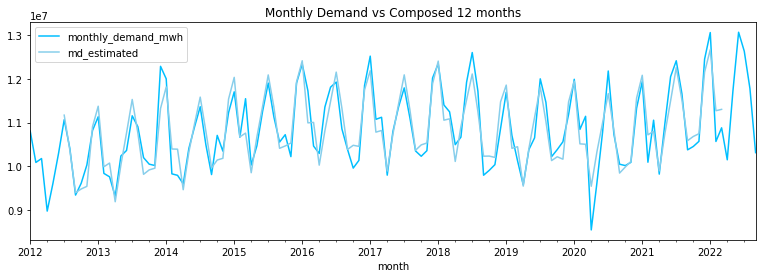

In [87]:
df_plot = df_mdemand[['month', 'monthly_demand_mwh']]
m_data = sd_12.trend + sd_12.seasonal# + sd_6.seasonal
df_plot['md_estimated'] = m_data.tolist()

plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['monthly_demand_mwh', 'md_estimated']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed 12 months", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#calculating mean absolute error and root mean squared error for model evaluation
MAE_sd = mean_absolute_error(df_compare[df_compare.md_estimated_12.notna()].monthly_demand_mwh.values
                            , df_compare[df_compare.md_estimated_12.notna()].md_estimated_12.values)
RMSE_sd = mean_squared_error(df_compare[df_compare.md_estimated_12.notna()].monthly_demand_mwh.values
                            , df_compare[df_compare.md_estimated_12.notna()].md_estimated_12.values, squared=False)
MAPE_sd = mean_absolute_percentage_error(df_compare[df_compare.md_estimated_12.notna()].monthly_demand_mwh.values
                            , df_compare[df_compare.md_estimated_12.notna()].md_estimated_12.values) * 100

print(f'Mean absolute error (MAE): {"%.0f" % MAE_sd}, Root mean squared error (RMSE): {"%.0f" % RMSE_sd}, Mean absolute percentage error (MAPE): {"%.1f" % MAPE_sd}% ')

## Forecast using Estimated Model as a Sum of components

### Forecast with a polinomial of 4° degree

In [21]:
df_future = pd.date_range(df_mdemand.month.max() + relativedelta(months=+1), periods=12, freq='MS').to_frame()
df_future.reset_index(drop=True, inplace=True)
df_future['monthly_demand_mwh'] = None
df_future.columns = ['month', 'monthly_demand_mwh']
df_forecast = pd.concat([df_mdemand[['month', 'monthly_demand_mwh']], df_future])

MAPE: 3.44 %


nan

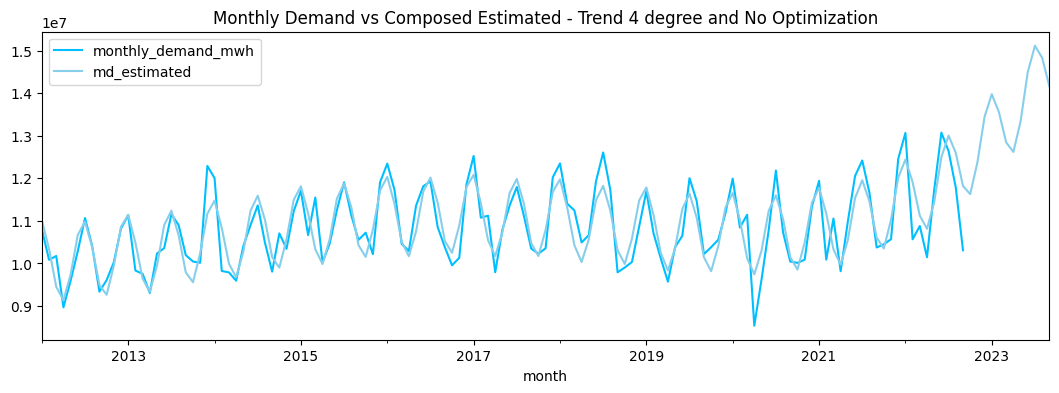

In [46]:
# Trend with polynomial of 4° degree: MAPE total 3.4%
pn = np.polynomial.polynomial.Polynomial.fit(mpl.dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values)
                                            , sd_12.trend[sd_12.trend.notna()].values, deg=4)
trend = pn(mpl.dates.date2num(df_forecast.month.values))

# Seasonality aproximated with Trigonometrics:
# datetime indices are converted to integers for 'fy' approximation function
tidx = mpl.dates.date2num(sd_12.seasonal.index.values)
params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal, p0=[950000, 1, 250000, -0.25, 1])

# Forecast
season = fy(mpl.dates.date2num(df_forecast.month.values), params_y[0], params_y[1], params_y[2], params_y[3], params_y[4])

md_estimated = trend + season
df_forecast['md_estimated'] = md_estimated.tolist()
MAPE_forecast = mean_absolute_percentage_error(df_forecast[~df_forecast.monthly_demand_mwh.isna()].monthly_demand_mwh.values
                            , df_forecast[~df_forecast.monthly_demand_mwh.isna()].md_estimated.values) * 100
print('MAPE:', round(MAPE_forecast, 2), '%')

plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['monthly_demand_mwh', 'md_estimated']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed Estimated - Trend 4 degree and No Optimization", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

### Forecast with a polinomial of 3° degree

MAPE: 3.59 %


nan

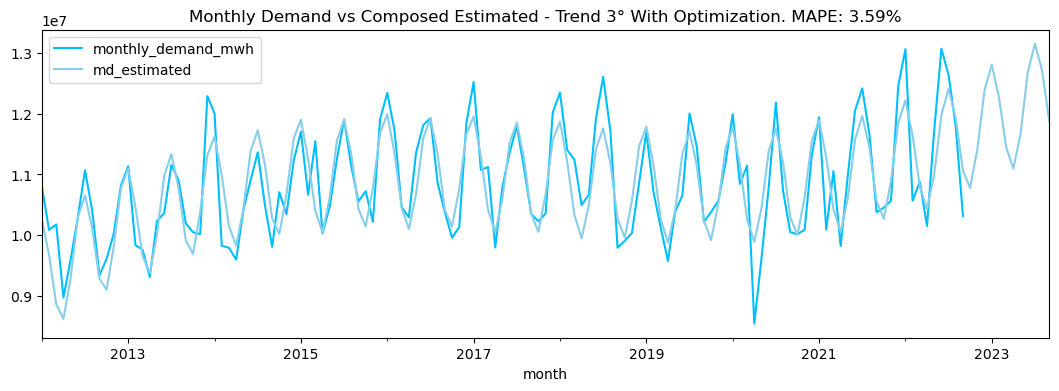

In [22]:
# Trend aproximated with polynomial of 4° degree by curve_fit --> goes up
# Trend aproximated with polynomial of 3° degree by curve_fit --> doesnt meet the highest peaks
x, y = mpl.dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values), sd_12.trend[sd_12.trend.notna()].values
popt, _ = curve_fit(objective3, x, y)
x = mpl.dates.date2num(df_forecast.month.values)
a, b, c, d = popt
# Forecast
trend = objective3(x, a, b, c, d)

# Seasonality aproximated with Trigonometrics:
# datetime indices are converted to integers for 'fy' approximation function
tidx = mpl.dates.date2num(sd_12.seasonal.index.values)
params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal, p0=[950000, 1, 250000, -0.25, 1])

# Forecast
season = fy(mpl.dates.date2num(df_forecast.month.values), params_y[0], params_y[1], params_y[2], params_y[3], params_y[4])

tidx = mpl.dates.date2num(sd_12.seasonal[sd_12.seasonal.notna()].index.values)
params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal[sd_12.seasonal.notna()], p0=[950000, 1, 250000, -0.25, 1])
season = fy(mpl.dates.date2num(df_forecast.month.values), params_y[0], params_y[1], params_y[2], params_y[3], params_y[4])

md_estimated = trend + season
df_forecast['md_estimated'] = md_estimated.tolist()
MAPE_forecast = mean_absolute_percentage_error(df_forecast[~df_forecast.monthly_demand_mwh.isna()].monthly_demand_mwh.values
                            , df_forecast[~df_forecast.monthly_demand_mwh.isna()].md_estimated.values) * 100
print('MAPE:', round(MAPE_forecast, 2), '%')

plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['monthly_demand_mwh', 'md_estimated']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed Estimated - Trend 3° With Optimization. MAPE: " + str(round(MAPE_forecast, 2)) + '%', xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

### Autocorrelation Test
For the seasonal lag, examine autocorrelation and partial autocorrelation plots in order to find regularly spaced peaks (whose height may decrease) and the corresponding "period" gives you the number of lags you should use if you need to perform seasonal differencing.

<span style="color: orange;">Seems that with a lag of 12 we have the maximum autocorrelation of 0.75.</span><br>

In [ ]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

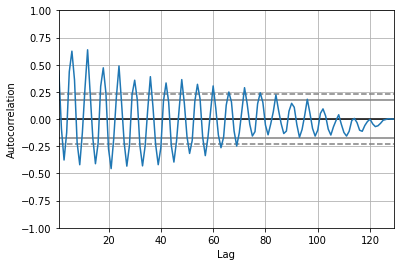

In [224]:
autocorrelation_plot(df_mdemand.monthly_demand_mwh.values)

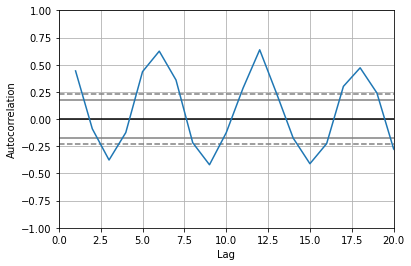

In [225]:
autocorrelation_plot(df_mdemand.monthly_demand_mwh.values).set_xlim([0, 20])
plt.show()

In [629]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

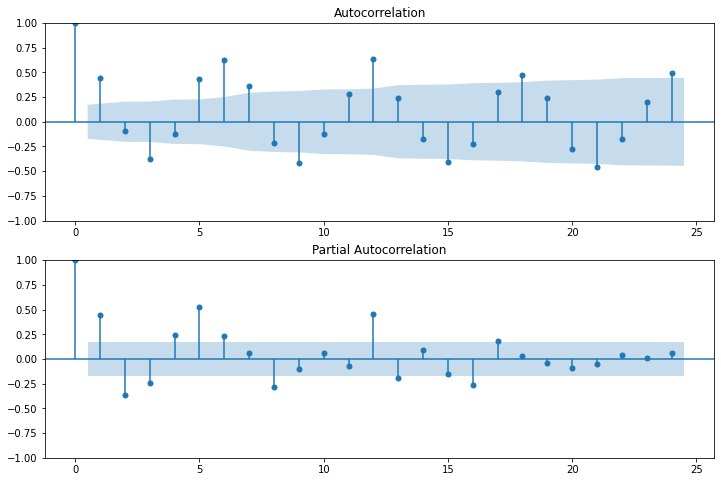

In [655]:
# parameter "d" you could take the first good spike of ACF plot. In this case, could be 6
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_mdemand.monthly_demand_mwh,lags=24,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_mdemand.monthly_demand_mwh,lags=24,ax=ax2)

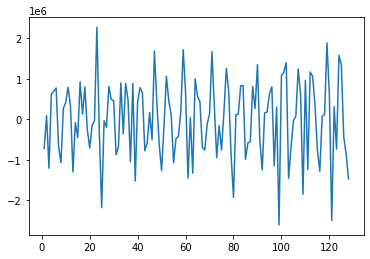

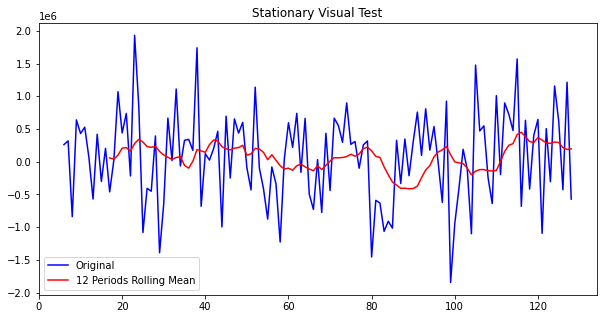

Results of Dickey Fuller Test:
Test Statistic                 -3.514
p-value                         0.008
#Lags Used                     10.000
Number of Observations Used   112.000
Critical Value (1%)            -3.490
Critical Value (5%)            -2.888
Critical Value (10%)           -2.581
dtype: float64


In [641]:
df_mdemand.monthly_demand_mwh.diff().plot()
test_stationarity(df_mdemand.monthly_demand_mwh.diff(6).dropna(), plot_std=False)

# ARIMA Model Try 1

PENDIENTE: https://pypi.org/project/pmdarima/ AUTO ARIMA EN python

In [19]:
from statsmodels.tsa.arima.model import ARIMA
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html

## Understanding statsmodels.ARIMA

### Model Training - No Hyperparameter Optimization

c:\Users\Usuario\miniconda3\envs\py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     monthly_demand_mwh   No. Observations:                  129
Model:                ARIMA(12, 1, 0)   Log Likelihood               -1927.664
Date:                Thu, 08 Dec 2022   AIC                           3881.327
Time:                        19:52:10   BIC                           3918.403
Sample:                    01-01-2012   HQIC                          3896.391
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1780      0.037     -4.806      0.000      -0.251      -0.105
ar.L2         -0.0814      0.032     -2.557      0.011      -0.144      -0.019
ar.L3         -0.1574      0.023     -6.909      0.0

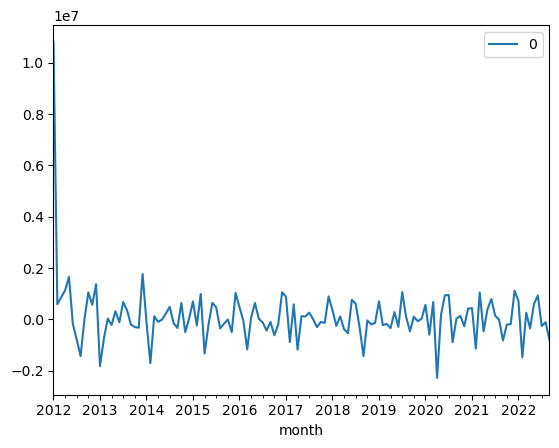

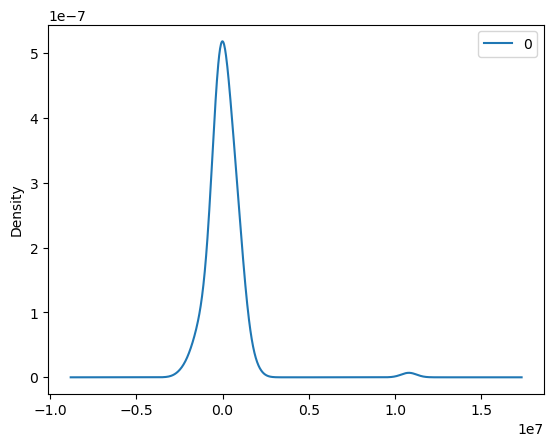

               0
count      129.0
mean    114388.6
std    1176916.8
min   -2274889.4
25%    -297034.0
50%      -2290.8
75%     572713.7
max   10804699.8


In [20]:
#series = df_roll.monthly_demand_mwh.values
#series.index = series.index.to_period('M')

# Add time index:
df_mdemand.set_index('month', inplace=True)
# fit model
model = ARIMA(df_mdemand[['monthly_demand_mwh']], order=(12, 1, 0), freq='MS') # MS: month start
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals --> lo ideal sería que tenga forma de campana, con media en 0.
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### Forecasting

In [52]:
# https://stackoverflow.com/questions/31690134/python-statsmodels-help-using-arima-model-for-time-series
# The statsmodel ARIMAResults object provides a forecast() function for making predictions.
# By default, this function makes a single step out-of-sample forecast. As such, we can call it directly and make our forecast. 
# The result of the forecast() function is an array containing the forecast value, the standard error of the forecast, 
# and the confidence interval information.
# one-step out-of sample forecast
forecast = model_fit.forecast()[0]
print('Forecast: %f' % forecast)

Forecast: 10861009.530982


In [53]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=6)
forecast

2022-10-01   10861009.5
2022-11-01   11306233.5
2022-12-01   12131596.0
2023-01-01   12022648.3
2023-02-01   10914110.3
2023-03-01   10824589.8
Freq: MS, Name: predicted_mean, dtype: float64

In [54]:
start_index = '2022-10-01'
end_index = '2023-10-01'
forecast = model_fit.predict(start=start_index, end=end_index, typ='levels')
forecast

2022-10-01   10861009.5
2022-11-01   11306233.5
2022-12-01   12131596.0
2023-01-01   12022648.3
2023-02-01   10914110.3
2023-03-01   10824589.8
2023-04-01   10758708.2
2023-05-01   11546480.6
2023-06-01   11942883.8
2023-07-01   11692559.7
2023-08-01   11234527.2
2023-09-01   10787437.6
2023-10-01   11149388.5
Freq: MS, Name: predicted_mean, dtype: float64

In [55]:
df_forecast = pd.DataFrame(data=forecast)
df_forecast.reset_index(inplace=True)
df_forecast.rename(columns={'index': 'month'}, inplace=True)
df_plot = df_mdemand.merge(right=df_forecast, on='month', how='outer')

nan

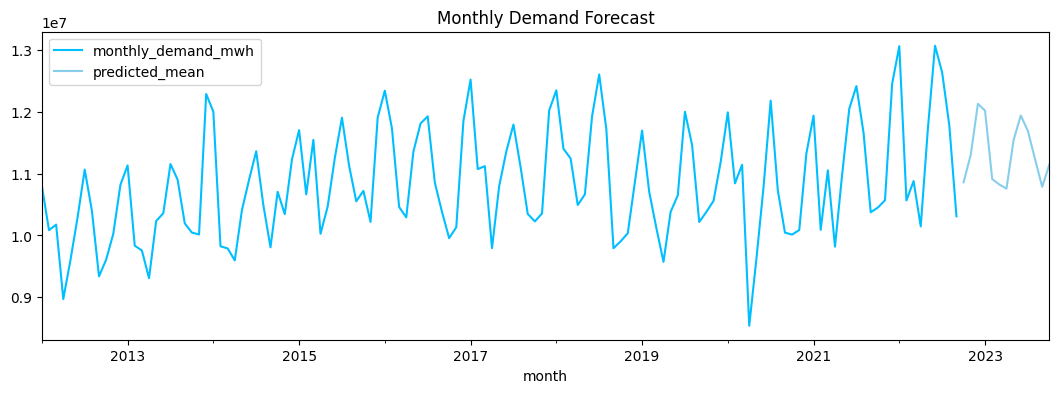

In [56]:
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['monthly_demand_mwh', 'predicted_mean']
    , right_feat_lst=[]
    , title="Monthly Demand Forecast", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

## ARIMA Experiments

In [21]:
from statsmodels.tsa.stattools import acf, pacf

### Generic Function for ARIMA train and forecast

In [ ]:
#df_ = df_mdemand
#model = ARIMA(df_[values_col], order=(p, d, q), freq=freq)

In [22]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

def arima_train_forecast(df, time_col, values_col, p, d, q, freq='MS', forecast_steps=12, fig_size=[13, 4], verbose=True
        , forecast=True):
    MAPE_ARIMA = None
    df_ = df.copy()
    # Add time index:
    if df_.index.name != time_col:
        df_.set_index(time_col, inplace=True)
    # fit model
    model = ARIMA(df_[values_col], order=(p, d, q), freq=freq) # MS: month start
    model_fit = model.fit()
    # summary of fit model
    #print(model_fit.summary())
    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels.tsa.arima.model.ARIMAResults
    if verbose:
        print('AIC (the lower, the better):', model_fit.aic.round(1), 'BIC (the lower, the better):', model_fit.bic.round(1))
        print('MAE (the lower, the better):', model_fit.mae.round(1), 'MSE:', model_fit.mse.round(1))
        print('log-likelihood (the higher, the better):', model_fit.llf.round(1))
    pvalues = model_fit.pvalues.reset_index()
    pvalues.columns = ['coef', 'pvalue']

    if verbose:
        print('Coef with p-value > 0.05:', len([x for x in pvalues.pvalue.values if x > 0.05]), 'over', len(pvalues.coef.values))
    # multi-step out-of-sample forecast
    if forecast:
        forecast = model_fit.forecast(steps=forecast_steps)
        df_forecast = pd.DataFrame(data=forecast)
        df_forecast.reset_index(inplace=True)
        df_forecast.rename(columns={'index': time_col}, inplace=True)
        forecast = pd.DataFrame(data=model_fit.predict(start=df_.index.min(), end=df_.index.max()))
        forecast.reset_index(inplace=True)
        forecast.rename(columns={'index': time_col}, inplace=True)
        MAPE_ARIMA = mean_absolute_percentage_error(df_.monthly_demand_mwh.values, forecast.predicted_mean.values) * 100        
        df_plot = df_.merge(right=df_forecast, on=time_col, how='outer')
        df_plot = df_plot.merge(right=forecast, on=time_col, how='outer')
        df_plot.predicted_mean_x.fillna(0, inplace=True)
        df_plot.predicted_mean_y.fillna(0, inplace=True)
        df_plot['predicted_mean'] = df_plot.predicted_mean_x + df_plot.predicted_mean_y
        if verbose:
            plot_title='ARIMA(' + str(p) + ', ' + str(d) + ', ' + str(q) + ') Forecast: ' + str(forecast_steps) + ' periods. '+\
                        'MAPE: '+str(round(MAPE_ARIMA, 2)) + '%'
            plot_df(df_plot, time_since=df_plot[time_col].min(), time_until=df_plot[time_col].max(), time_col=time_col
                        , left_feat_lst=[values_col, 'predicted_mean']
                        , right_feat_lst=[]
                        , title=plot_title, xposition=[], yposition=[]
                        , fig_size=fig_size, return_df=False, left_feat_markers=None, right_feat_markers=None
                        , xlim=None, ylim=None, texts=None)
    else:
        df_forecast = df_[-int(df.shape[0]*0.3):]
        forecast = model_fit.predict(start=df_forecast.index.min(), end=df_forecast.index.max())
        df_forecast['predicted_mean'] = forecast.values
        df_forecast.reset_index(inplace=True)
        df_forecast.drop(columns='monthly_demand_mwh', inplace=True)
        df_plot = df_.merge(df_forecast, on='month', how='left')
        MAPE_ARIMA = mean_absolute_percentage_error(df_plot[-int(df.shape[0]*0.3):].monthly_demand_mwh.values
                , df_plot[-int(df.shape[0]*0.3):].predicted_mean.values) * 100
        if verbose:
            print(f'Mean absolute percentage error (MAPE): {"%.1f" % MAPE_ARIMA}% ')
            plot_title='ARIMA(' + str(p) + ', ' + str(d) + ', ' + str(q) + ') Test Set Validation'
            plot_df(df_plot, time_since=df_plot[time_col].min(), time_until=df_plot[time_col].max(), time_col=time_col
                            , left_feat_lst=[values_col, 'predicted_mean']
                            , right_feat_lst=[]
                            , title=plot_title, xposition=[], yposition=[]
                            , fig_size=fig_size, return_df=False, left_feat_markers=None, right_feat_markers=None
                            , xlim=None, ylim=None, texts=None)
    return model_fit, MAPE_ARIMA

### Experiments

AIC (the lower, the better): 3881.3 BIC (the lower, the better): 3918.4
MAE (the lower, the better): 603712.2 MSE: 1387480484455.3
log-likelihood (the higher, the better): -1927.7
Coef with p-value > 0.05: 3 over 13
Mean absolute percentage error (MAPE): 5.1% 


(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2656098a9a0>,
 5.114403573301609)

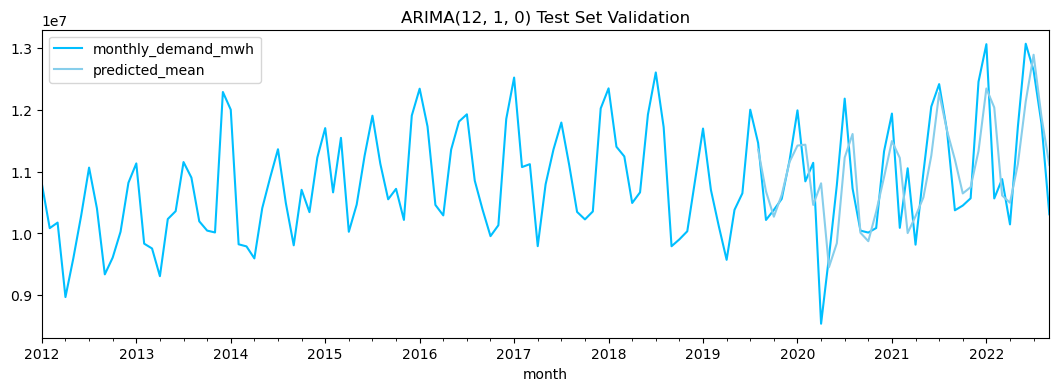

In [23]:
# Use last 12 month on AR component and 1 level of differenciation
arima_train_forecast(df=df_mdemand, time_col='month', values_col='monthly_demand_mwh', p=12, d=1, q=0, freq='MS', forecast_steps=12
    , fig_size=[13, 4], forecast=False)

AIC (the lower, the better): 3872.2 BIC (the lower, the better): 3892.2
MAE (the lower, the better): 672054.9 MSE: 1484770919692.5
log-likelihood (the higher, the better): -1929.1
Coef with p-value > 0.05: 1 over 7
Mean absolute percentage error (MAPE): 6.2% 


(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2988ff527c0>,
 6.168153180405897)

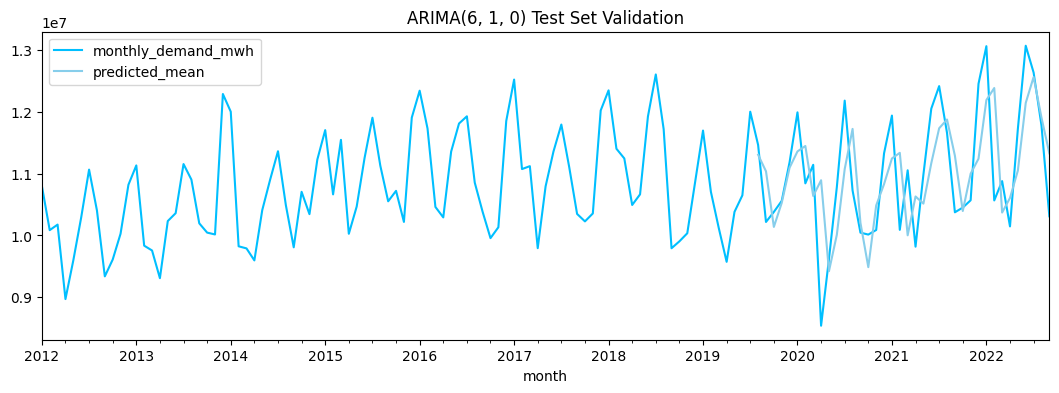

In [59]:
# Use 6 month on AR component and 1 level of differenciation
arima_train_forecast(df=df_mdemand, time_col='month', values_col='monthly_demand_mwh', p=6, d=1, q=0, freq='MS', forecast_steps=12
    , fig_size=[13, 4], forecast=False)

AIC (the lower, the better): 3767.8 BIC (the lower, the better): 3810.7
MAE (the lower, the better): 362785.4 MSE: 228677924993.0
log-likelihood (the higher, the better): -1868.9
Coef with p-value > 0.05: 11 over 15
Mean absolute percentage error (MAPE): 3.5% 


(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x29894be90a0>,
 3.496758389886714)

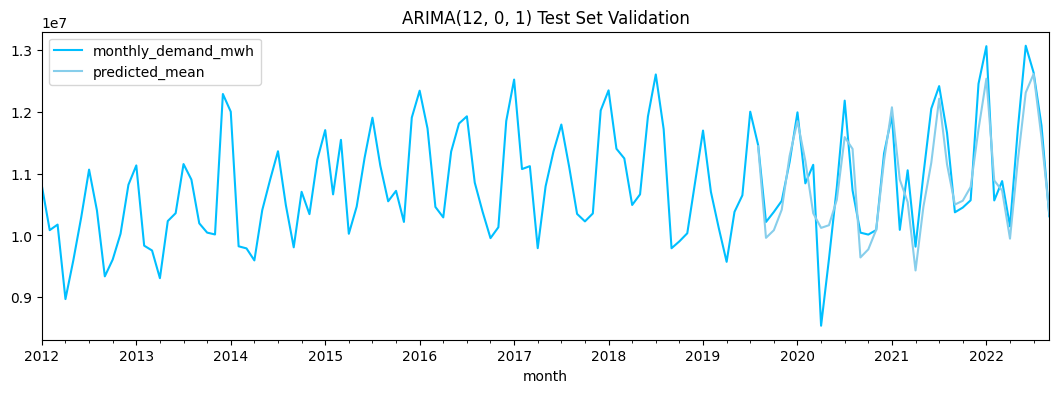

In [60]:
arima_train_forecast(df=df_mdemand, time_col='month', values_col='monthly_demand_mwh', p=12, d=0, q=1, freq='MS', forecast_steps=12
    , fig_size=[13, 4], forecast=False)

AIC (the lower, the better): 3775.6 BIC (the lower, the better): 3832.8
MAE (the lower, the better): 358825.0 MSE: 224712480203.0
log-likelihood (the higher, the better): -1867.8
Coef with p-value > 0.05: 17 over 20
Mean absolute percentage error (MAPE): 3.3% 


(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2988fefa2e0>,
 3.2677236113824315)

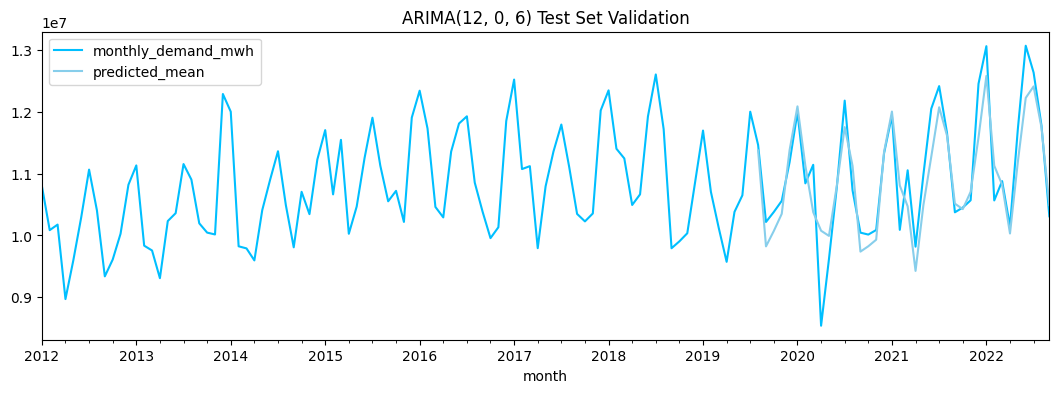

In [61]:
# Check MAPE:
arima_train_forecast(df=df_mdemand, time_col='month', values_col='monthly_demand_mwh', p=12, d=0, q=6, freq='MS', forecast_steps=12
    , fig_size=[13, 4], forecast=False)

AIC (the lower, the better): 3775.6 BIC (the lower, the better): 3832.8
MAE (the lower, the better): 358825.0 MSE: 224712480203.0
log-likelihood (the higher, the better): -1867.8
Coef with p-value > 0.05: 17 over 20


(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x29894be9c10>,
 3.3444160733707187)

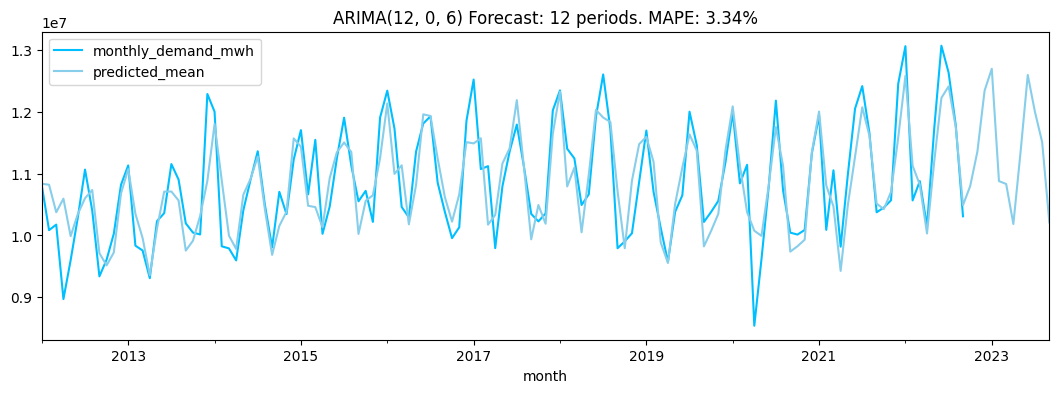

In [62]:
# Predict with this model:
arima_train_forecast(df=df_mdemand, time_col='month', values_col='monthly_demand_mwh', p=12, d=0, q=6, freq='MS', forecast_steps=12
    , fig_size=[13, 4], forecast=True)

AIC (the lower, the better): 3772.9 BIC (the lower, the better): 3838.7
MAE (the lower, the better): 339349.1 MSE: 206994875388.5
log-likelihood (the higher, the better): -1863.4
Coef with p-value > 0.05: 19 over 23
Mean absolute percentage error (MAPE): 3.3% 


(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x298901ce580>,
 3.3147935149982652)

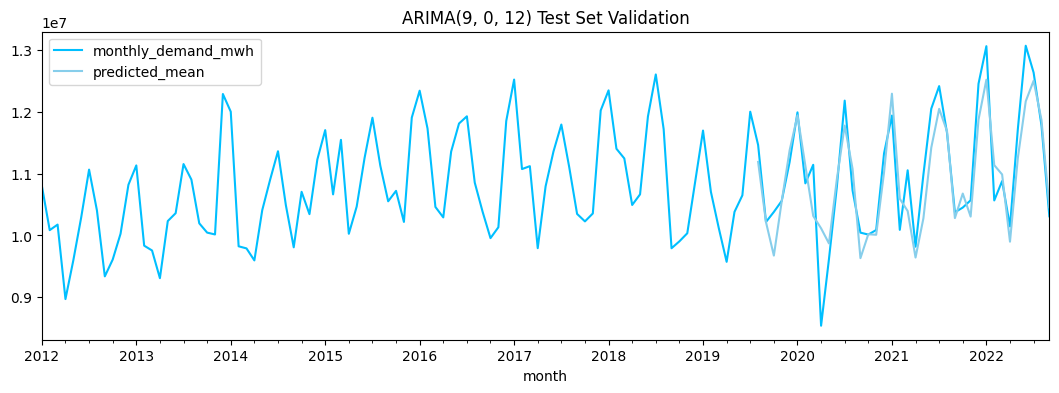

In [63]:
arima_train_forecast(df=df_mdemand, time_col='month', values_col='monthly_demand_mwh', p=9, d=0, q=12, freq='MS', forecast_steps=12
    , fig_size=[13, 4], forecast=False)

AIC (the lower, the better): 3772.9 BIC (the lower, the better): 3838.7
MAE (the lower, the better): 339349.1 MSE: 206994875388.5
log-likelihood (the higher, the better): -1863.4
Coef with p-value > 0.05: 19 over 23


(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x298901c1c40>,
 3.157647348033633)

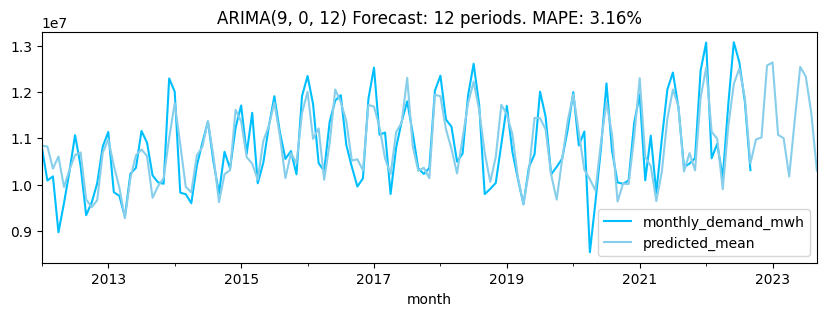

In [64]:
arima_train_forecast(df=df_mdemand, time_col='month', values_col='monthly_demand_mwh', p=9, d=0, q=12, freq='MS', forecast_steps=12
    , fig_size=[10, 3], forecast=True)

AIC (the lower, the better): 2035.6 BIC (the lower, the better): 2087.0
MAE (the lower, the better): 348581.0 MSE: 209183970442.4
log-likelihood (the higher, the better): -994.8
Coef with p-value > 0.05: 21 over 23
Mean absolute percentage error (MAPE): 2.8% 


(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2988ff95910>,
 2.8299644650889983)

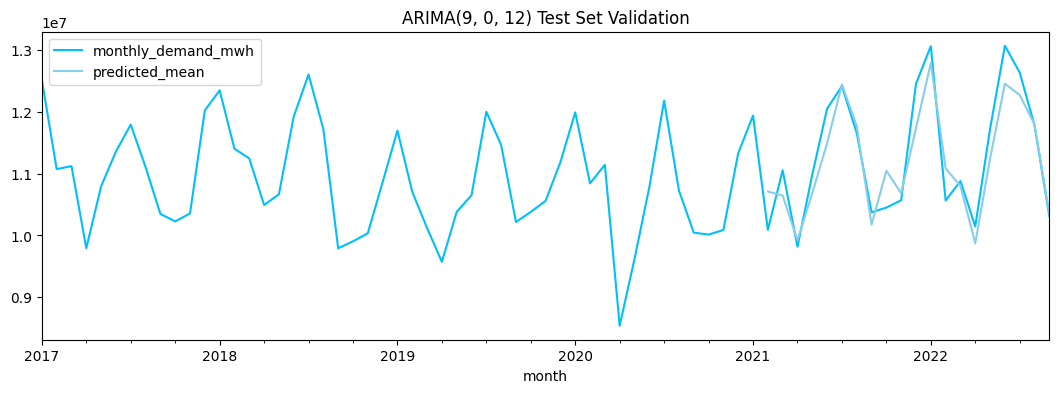

In [65]:
# Train with last years:
if df_mdemand.index.name == 'month':
    df_mdemand.reset_index(inplace=True, drop=False)
arima_train_forecast(df=df_mdemand[df_mdemand.month>='2017-01-01'], time_col='month', values_col='monthly_demand_mwh'
    , p=9, d=0, q=12, freq='MS', forecast_steps=12
    , fig_size=[13, 4], forecast=False)

AIC (the lower, the better): 2035.6 BIC (the lower, the better): 2087.0
MAE (the lower, the better): 348581.0 MSE: 209183970442.4
log-likelihood (the higher, the better): -994.8
Coef with p-value > 0.05: 21 over 23
3.202960401689128


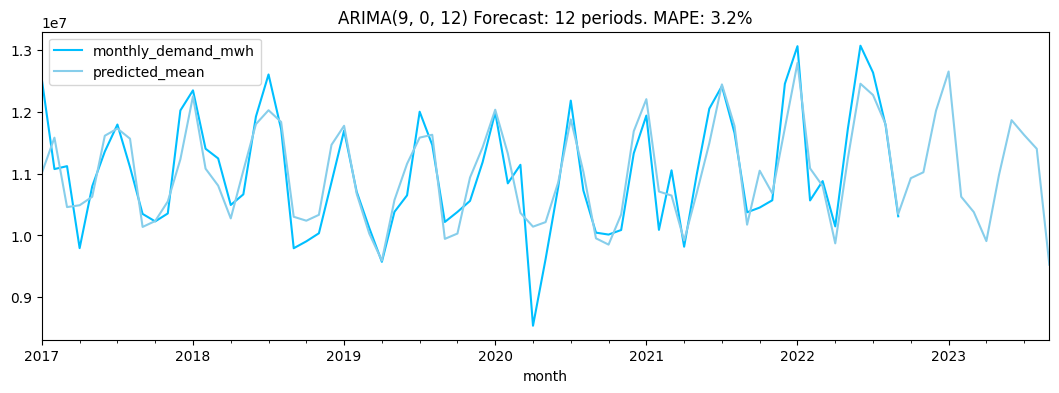

In [66]:
model_fit, mape = arima_train_forecast(df=df_mdemand[df_mdemand.month>='2017-01-01'], time_col='month', values_col='monthly_demand_mwh'
    , p=9, d=0, q=12, freq='MS', forecast_steps=12, fig_size=[13, 4], forecast=True)
print(mape)

### Grid Search of optimal ARIMA parameters

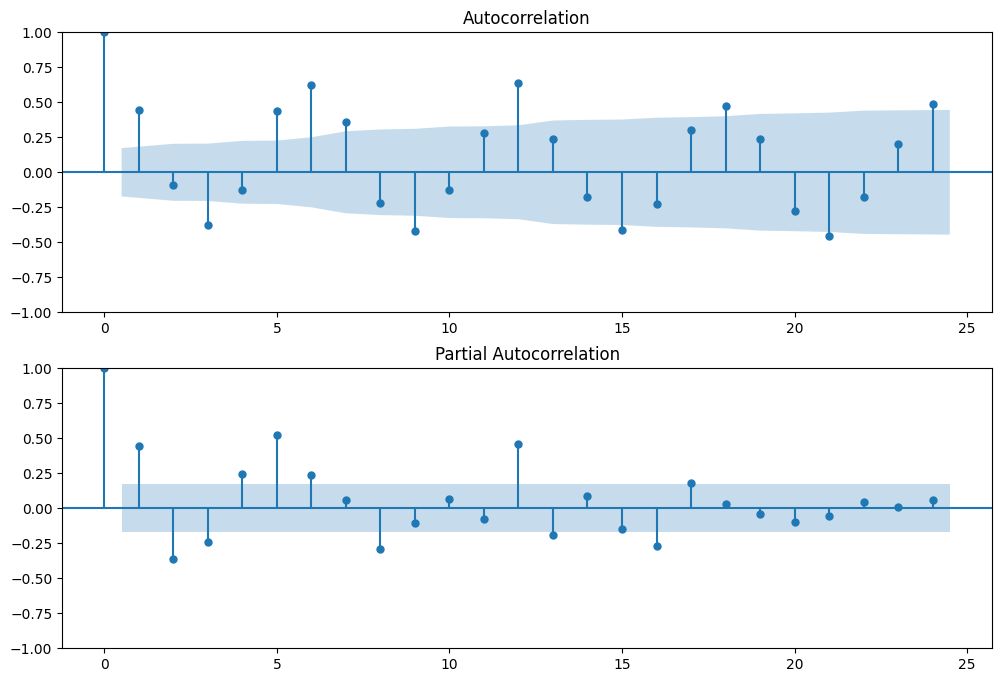

In [67]:
# parameter "p" could be taken from PACF: 5?
# parameter "d" you could take the first good spike of ACF plot. In this case, could be 6
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_mdemand.monthly_demand_mwh,lags=24,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_mdemand.monthly_demand_mwh,lags=24,ax=ax2)

In [68]:
dataset = df_mdemand[['monthly_demand_mwh']].copy()
# prepare training dataset
train_size = int(len(dataset) * 0.7)
df_train, df_test = dataset[0:train_size], dataset[train_size:]
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5, 6, 8, 12]
d_values = [0, 1]
q_values = [0, 3, 5, 6, 7, 9, 12]
best_score, best_cfg = float("inf"), None
for p in p_values:
	for d in d_values:
		for q in q_values:
			order = (p, d, q)
			try:
				model_fit, mape = arima_train_forecast(df=df_mdemand, time_col='month', values_col='monthly_demand_mwh'
							, p=p, d=d, q=q, freq='MS', forecast_steps=12, fig_size=[13, 4], verbose=False, forecast=False)
				#mse = evaluate_arima_model(dataset, order)
				#if model_fit.mae < best_score:
				if mape < best_score:
					#best_score, best_cfg = model_fit.mae, order
					best_score, best_cfg = mape, order
					#print('ARIMA%s MAE=%.3f' % (order, model_fit.mae))
					print('ARIMA%s MAPE=%.2f %' % (order, mape))
			except:
				continue
#print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))
print('Best ARIMA%s MAPE=%.3f' % (best_cfg, best_score))

Best ARIMA(12, 0, 6) MAPE=3.268


AIC (the lower, the better): 3775.6 BIC (the lower, the better): 3832.8
MAE (the lower, the better): 358810.6 MSE: 224710938856.6
log-likelihood (the higher, the better): -1867.8
Coef with p-value > 0.05: 17 over 20
Mean absolute percentage error (MAPE): 3.3% 


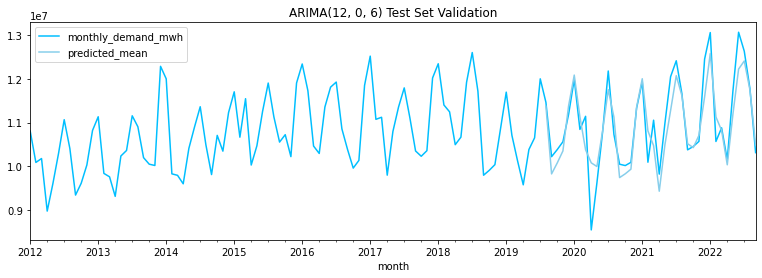

In [127]:
p, d, q = 12, 0, 6
model_fit, mape = arima_train_forecast(df=df_mdemand, time_col='month', values_col='monthly_demand_mwh'
		, p=p, d=d, q=q, freq='MS', forecast_steps=12, fig_size=[13, 4], verbose=True, forecast=False)

AIC (the lower, the better): 3775.6 BIC (the lower, the better): 3832.8
MAE (the lower, the better): 358825.0 MSE: 224712480203.0
log-likelihood (the higher, the better): -1867.8
Coef with p-value > 0.05: 17 over 20


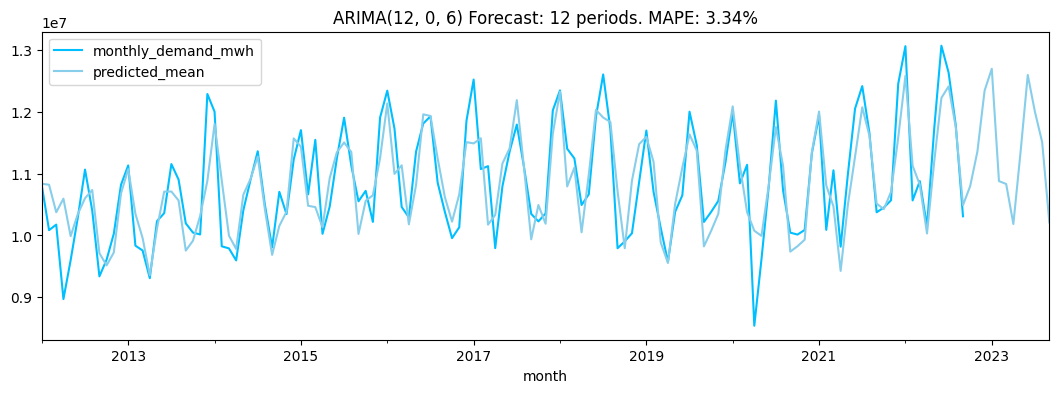

In [69]:
p, d, q = 12, 0, 6
model_fit, mape = arima_train_forecast(df=df_mdemand, time_col='month', values_col='monthly_demand_mwh'
		, p=p, d=d, q=q, freq='MS', forecast_steps=12, fig_size=[13, 4], verbose=True, forecast=True)

AIC (the lower, the better): 2031.2 BIC (the lower, the better): 2075.9
MAE (the lower, the better): 346494.5 MSE: 211551118606.9
log-likelihood (the higher, the better): -995.6
Coef with p-value > 0.05: 18 over 20


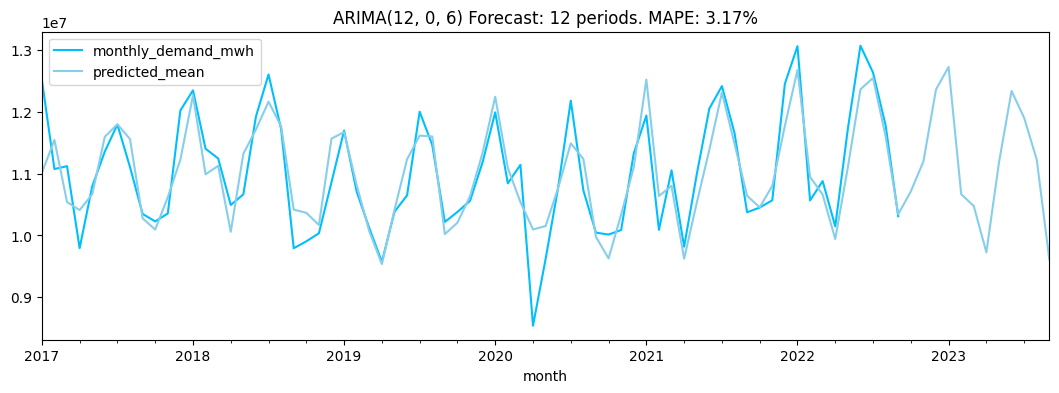

In [70]:
p, d, q = 12, 0, 6
model_fit, mape = arima_train_forecast(df=df_mdemand[df_mdemand.month>='2017-01-01'], time_col='month', values_col='monthly_demand_mwh'
		, p=p, d=d, q=q, freq='MS', forecast_steps=12, fig_size=[13, 4], verbose=True, forecast=True)

In [685]:
# Array containing autoregressive lag polynomial coefficients, ordered from lowest degree to highest. 
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).
model_fit.polynomial_ar.round(3)

array([ 1.   , -0.273, -0.071, -0.013, -0.111, -0.272, -0.143, -0.041,
        0.221,  0.105, -0.008,  0.174, -0.491])

# SARIMAX
https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/<br>
4 more parameters: Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity.

In [156]:
#import statsmodels.api as sm
data = df_mdemand.copy()
model=sm.tsa.statespace.SARIMAX(data.monthly_demand_mwh, order=(1, 1, 1), seasonal_order=(1,1,1,12))
results=model.fit()

In [157]:
data.shape

(129, 2)

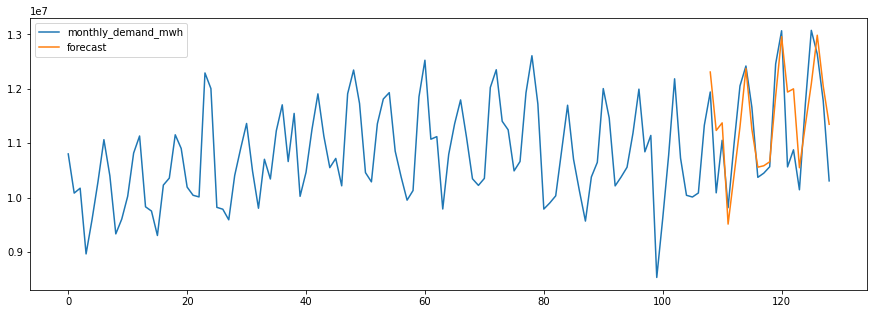

In [159]:
data['forecast']=results.predict(start=108, end=128, dynamic=True)
data[['monthly_demand_mwh','forecast']].plot(figsize=(15, 5))

In [161]:
mape = mean_absolute_percentage_error(data[108:].monthly_demand_mwh.values
                , data[108:].forecast.values) * 100
print('MAPE SARIMAX (1, 1, 1, 12):', round(mape, 2), '%')

MAPE SARIMAX (1, 1, 1, 12): 4.69 %


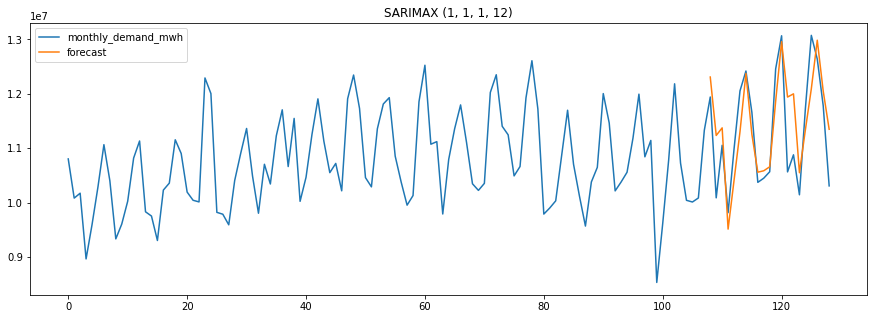

In [171]:
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12
data = df_mdemand.copy()
model=sm.tsa.statespace.SARIMAX(data.monthly_demand_mwh, order=(p, d, q), seasonal_order=(P, D, Q, s))
results=model.fit()
data['forecast']=results.predict(start=108, end=140, dynamic=True)
data[['monthly_demand_mwh','forecast']].plot(figsize=(15, 5), title='SARIMAX ('+ str(P) + ', ' + str(D) +', ' + str(Q) + ', ' + str(s) +')')
#mape = mean_absolute_percentage_error(data[108:].monthly_demand_mwh.values, data[108:].forecast.values) * 100
#print('MAPE SARIMAX (', P, ',', D, ',', Q, ',', s, '):', round(mape, 2), '%')

# Test of Prophet with Monthly Data

In [24]:
# https://pythonlang.dev/repo/facebook-prophet/
# prophet uses stan as base, so first you have to have pystan installed:
# pip install Cython
# pip install pystan==2.19.1.1
# pip install prophet

# SIN EMBARGO, finalmente funcionó con sólo:
# conda install -c conda-forge prophet

from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [25]:
if df_mdemand.index.name == 'month':
    df_mdemand.reset_index(inplace=True)

In [27]:
# Prophet also imposes the strict condition that the input columns must be named as ds (the time column) and y (the metric column).
df_mdemand_ph = df_mdemand.copy()
df_mdemand_ph.rename(columns={'month': 'ds', 'monthly_demand_mwh': 'y'}, inplace=True)

# set the uncertainty interval to 95% (the Prophet default is 80%)
# 4 minutes!!
model = Prophet(interval_width=0.95)#, stan_backend='CMDSTANPY')
# Fit to data
model.fit(df_mdemand_ph)

19:53:07 - cmdstanpy - INFO - Chain [1] start processing
19:53:07 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Forecast next 2 months:
# In Python, the frequency can be anything from the pandas list of frequency strings here: 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases .
future_dates = model.make_future_dataframe(periods=12, freq='MS')
future_dates.tail()

ds
136 2023-05-01
137 2023-06-01
138 2023-07-01
139 2023-08-01
140 2023-09-01

In [29]:
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2012-01-01 10997360.9  10235324.5  11755927.0
1 2012-02-01 10112635.6   9425430.3  10858794.4
2 2012-03-01  9995897.7   9260738.9  10784537.5
3 2012-04-01  8807159.3   8094162.1   9585341.5
4 2012-05-01  9835891.1   9078463.3  10639403.4

nan

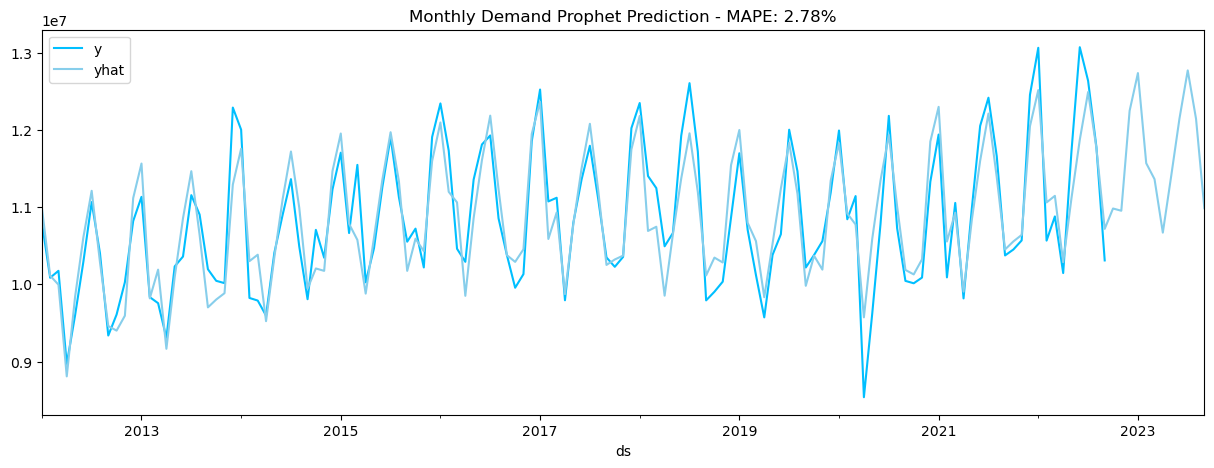

In [30]:
df_plot = df_mdemand_ph.merge(right=forecast[['ds', 'yhat']], on='ds', how='outer')
MAPE_prophet = mean_absolute_percentage_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values) * 100
plot_df(df_plot, time_since='2012-01-01', time_until=df_plot.ds.max(), time_col='ds'
    , left_feat_lst=['y', 'yhat']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Monthly Demand Prophet Prediction - MAPE: " + str(round(MAPE_prophet,2)) + '%', xposition=[], yposition=[]
    , fig_size=[15, 5], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None
        , ylim=[], texts=None)

### DANGER: The monthly difference between y and yhat shouldnt be more than 5%

In [31]:
# DANGER: The monthly difference between y and yhat shouldnt be more than 5%
(df_plot.y.fillna(0)[-24:-12] - df_plot.yhat.fillna(0)[-24:-12]) / df_plot.y.fillna(0)[-24:-12] * 100

117   -1.0
118   -0.7
119    3.3
120    4.2
121   -4.7
122   -2.5
123   -1.4
124    5.2
125    9.2
126    1.2
127    0.1
128   -4.0
dtype: float64

In [180]:
#calculating mean absolute error and root mean squared error for model evaluation
MAE_prophet = mean_absolute_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values)
RMSE_prophet = mean_squared_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values, squared=False)
MAPE_prophet = mean_absolute_percentage_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values) * 100

print(f'Mean absolute error (MAE): {"%.0f" % MAE_prophet}, Root mean squared error (RMSE): {"%.0f" % RMSE_prophet},',
    f' Mean absolute percentage error (MAPE): {"%.1f" % MAPE_prophet}% ')

Mean absolute error (MAE): 301208, Root mean squared error (RMSE): 377493,  Mean absolute percentage error (MAPE): 2.8% 


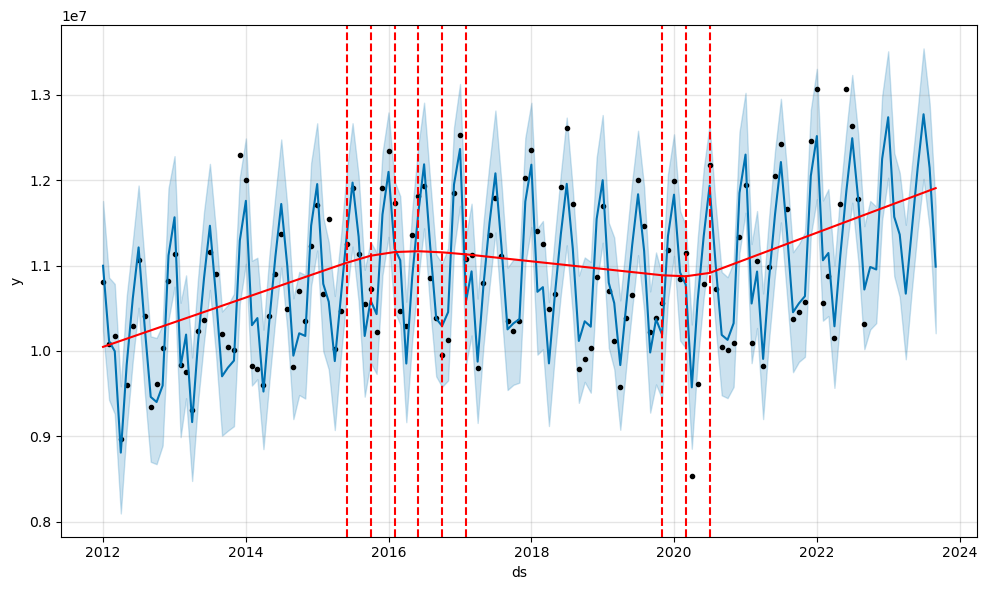

In [32]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [204]:
# To list changepoints:
#df_mdemand_ph.loc[df_mdemand_ph["ds"].isin(model.changepoints)]

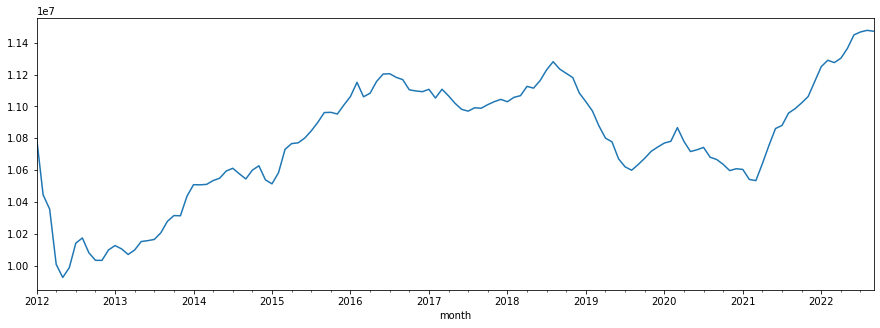

In [198]:
# Remember the trend:
df_mdemand.set_index('month').monthly_demand_mwh.rolling(window='365D').mean().plot(figsize=(15, 5))

In [199]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
# 4 minutes!!
model = Prophet(interval_width=0.95, changepoints=['2016-0-01', '2016-04-01', '2016-05-01', '2016-06-01'
    , '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01'
    , '2019-05-01', '2019-06-01', '2019-07-01', '2021-02-01', '2021-03-01', '2021-04-01'])
# Fit to data
model.fit(df_mdemand_ph)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


nan

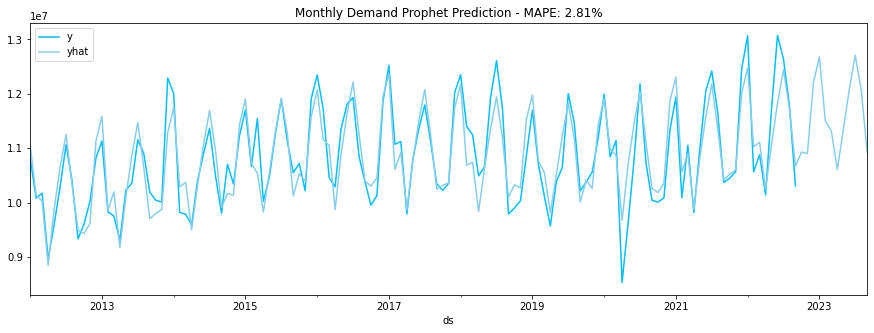

In [205]:
# Forecast next 2 months:
future_dates = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()
df_plot = df_mdemand_ph.merge(right=forecast[['ds', 'yhat']], on='ds', how='outer')
MAPE_prophet = mean_absolute_percentage_error(df_plot.dropna().y.values, df_plot.dropna().yhat.values) * 100
plot_df(df_plot, time_since='2012-01-01', time_until=df_plot.ds.max(), time_col='ds'
    , left_feat_lst=['y', 'yhat']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Monthly Demand Prophet Prediction - MAPE: " + str(round(MAPE_prophet,2)) + '%', xposition=[], yposition=[]
    , fig_size=[15, 5], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None
        , ylim=[], texts=None)

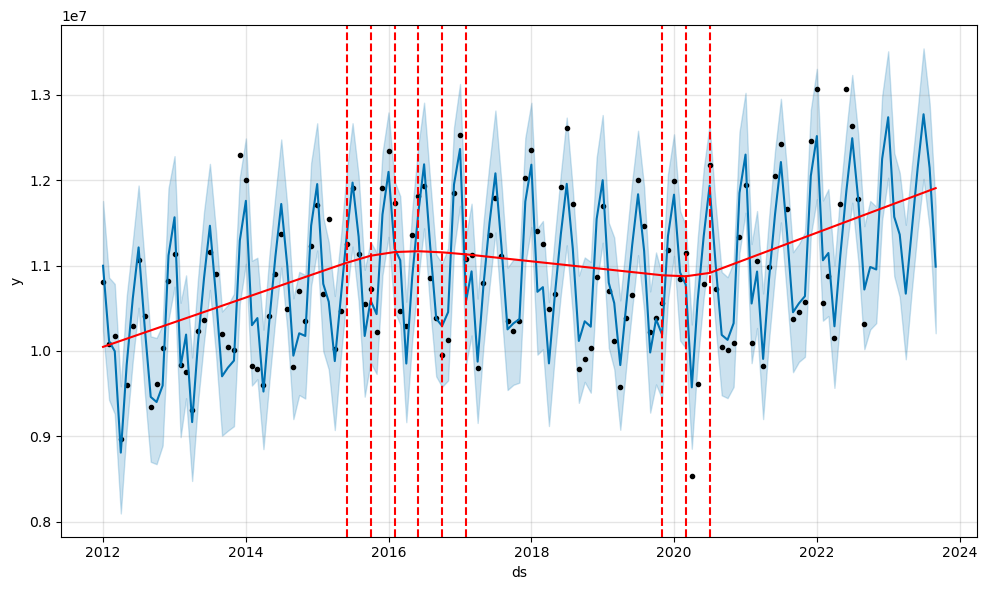

In [33]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)